# Import

## Library

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings

# Plotting and visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from scipy.stats import probplot

# Set global font size for Seaborn
sns.set(font_scale=1.4)  # This will scale the fonts by a factor of 1.4
# Set the default font size to 18 for all text elements
plt.rcParams.update({'font.size': 18})

# PyTorch and deep learning
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from d2l import torch as d2l

# Preprocessing and feature engineering
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import NearestNeighbors
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import category_encoders as ce
import pylab

# Clustering
from sklearn.cluster import DBSCAN, KMeans

# Modeling and evaluation
from sklearn import metrics
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, LassoCV, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ParameterGrid, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
from xgboost import plot_importance

# Miscellaneous
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
%load_ext autoreload
%autoreload 2
from utils import *


## Data

In [2]:
# main data
train_data_path = './dataset/train.csv'
test_data_path = './dataset/test.csv'

# auxiliary data
mrt_exist_data_path = './dataset/auxiliary-data/sg-mrt-existing-stations.csv'
mrt_planned_data_path = './dataset/auxiliary-data/sg-mrt-planned-stations.csv'
mall_data_path = './dataset/auxiliary-data/sg-shopping-malls.csv'
primary_school_data_path = './dataset/auxiliary-data/sg-primary-schools.csv'
coe_price_data_path = './dataset/auxiliary-data/sg-coe-prices.csv'
stock_price_data_path = './dataset/auxiliary-data/sg-stock-prices.csv'

# Load Data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
test_data['monthly_rent'] = 0
mrt_exist_data = pd.read_csv(mrt_exist_data_path)
mrt_planned_data = pd.read_csv(mrt_planned_data_path)
mall_data = pd.read_csv(mall_data_path)
primary_school_data = pd.read_csv(primary_school_data_path)
coe_price_data = pd.read_csv(coe_price_data_path)
stock_price_data = pd.read_csv(stock_price_data_path)

# 0. Cleaning

1. 新加坡的住宅物业: 二房式灵活组屋（2-room flexi flat）、三房式组屋（3-room flat）、四房式组屋（4-room flat）、五房式组屋（5-room flat）、三代同堂组屋（3Gen flat）、公寓式组屋（Executive flat）

In [3]:
# flat_type
train_data['flat_type'] = train_data['flat_type'].str.replace("-", " ")
test_data['flat_type'] = test_data['flat_type'].str.replace("-", " ")

# mrt_planned
mrt_planned_data['opening_year'].replace('TBA', pd.NA, inplace=True)
mrt_planned_data.dropna(subset=['opening_year'], inplace=True)
# only include those planned within 3 years, due to the policy restriction
mrt_planned_data = mrt_planned_data[(mrt_planned_data['opening_year']).astype(int) < 2029]

train_data.head()
print(train_data.shape)

(60000, 16)


# 1. EDA - Main Data


## 1.1 General Info

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rent_approval_date   60000 non-null  object 
 1   town                 60000 non-null  object 
 2   block                60000 non-null  object 
 3   street_name          60000 non-null  object 
 4   flat_type            60000 non-null  object 
 5   flat_model           60000 non-null  object 
 6   floor_area_sqm       60000 non-null  float64
 7   furnished            60000 non-null  object 
 8   lease_commence_date  60000 non-null  int64  
 9   latitude             60000 non-null  float64
 10  longitude            60000 non-null  float64
 11  elevation            60000 non-null  float64
 12  subzone              60000 non-null  object 
 13  planning_area        60000 non-null  object 
 14  region               60000 non-null  object 
 15  monthly_rent         60000 non-null 

## 1.2 Descriptive Statistics

In [5]:
train_data.describe()

floor_area_sqm  lease_commence_date      latitude     longitude  \
count    60000.000000         60000.000000  60000.000000  60000.000000   
mean        94.480458          1990.876367      1.359443    103.840110   
std         24.082642            12.141435      0.042505      0.071627   
min         34.000000          1966.000000      1.270380    103.685228   
25%         73.000000          1981.000000      1.330939    103.778803   
50%         93.000000          1988.000000      1.354024    103.845301   
75%        110.000000          2000.000000      1.386968    103.897418   
max        215.000000          2019.000000      1.457071    103.964915   

       elevation  monthly_rent  
count    60000.0  60000.000000  
mean         0.0   2590.328333  
std          0.0    714.910468  
min          0.0    300.000000  
25%          0.0   2100.000000  
50%          0.0   2400.000000  
75%          0.0   3000.000000  
max          0.0   6950.000000

## 1.3 Visualization of General Info

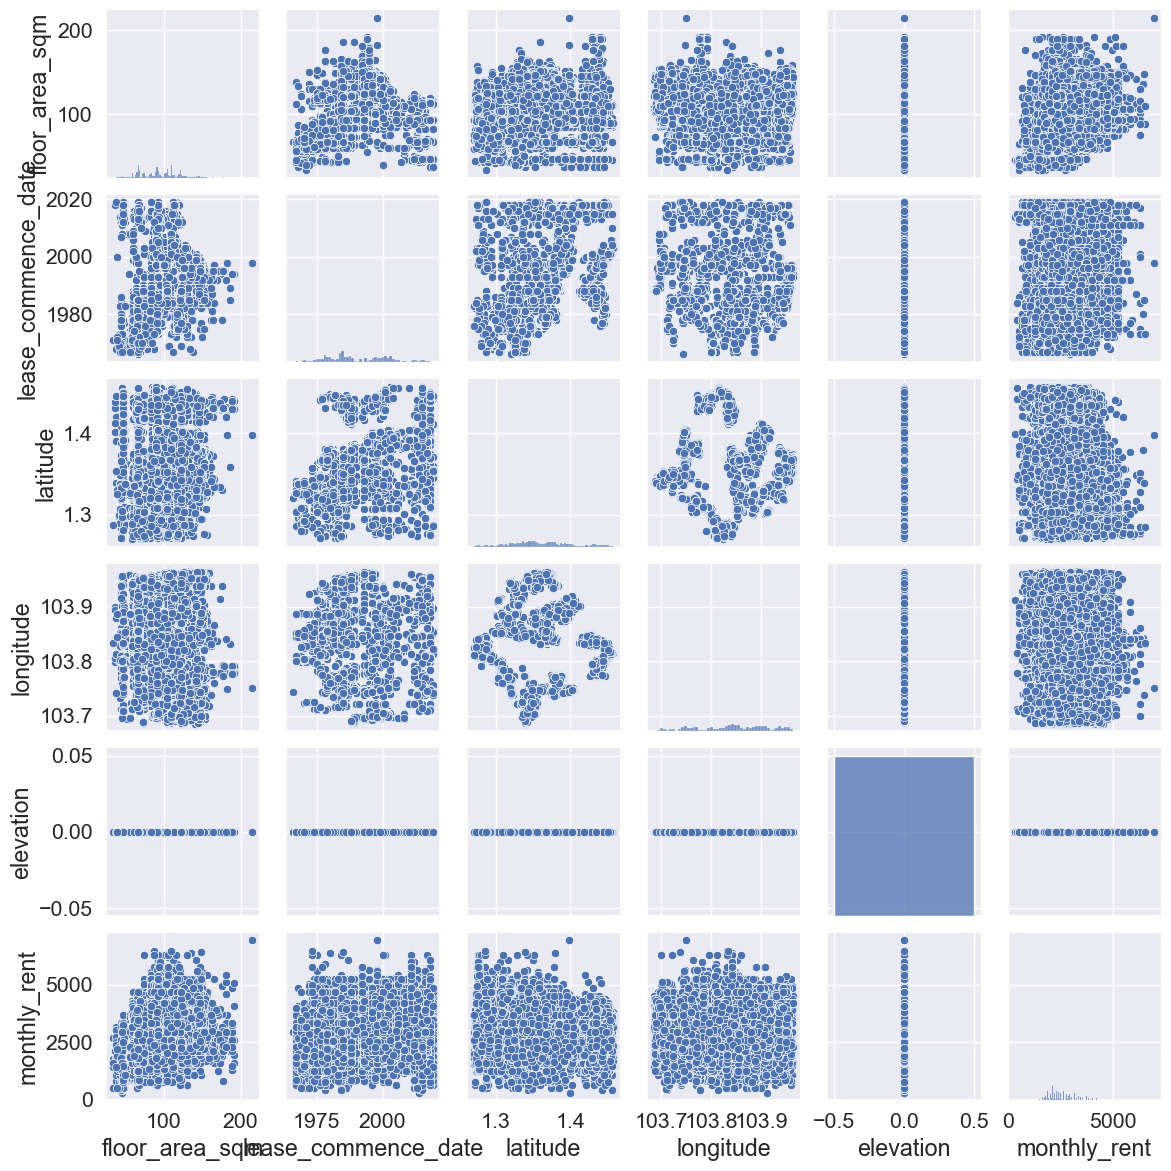

In [6]:
sns.pairplot(train_data,height=2)
plt.show()

#### 1.4 b) Feature Correlations

In [7]:
# # Compute the correlation matrix
# corr_matrix = train_data.corr()
#
# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Feature Correlation Heatmap')
# plt.show()

### Observations

There is no null value for any column in the dataset.
The scale of numerical data varies significantly, remember to normalize before analysis
There are natural groups but not clear, further observation required

## 1.4 Univariate Analysis - Categorical

#### 1.4 a) town & subarea

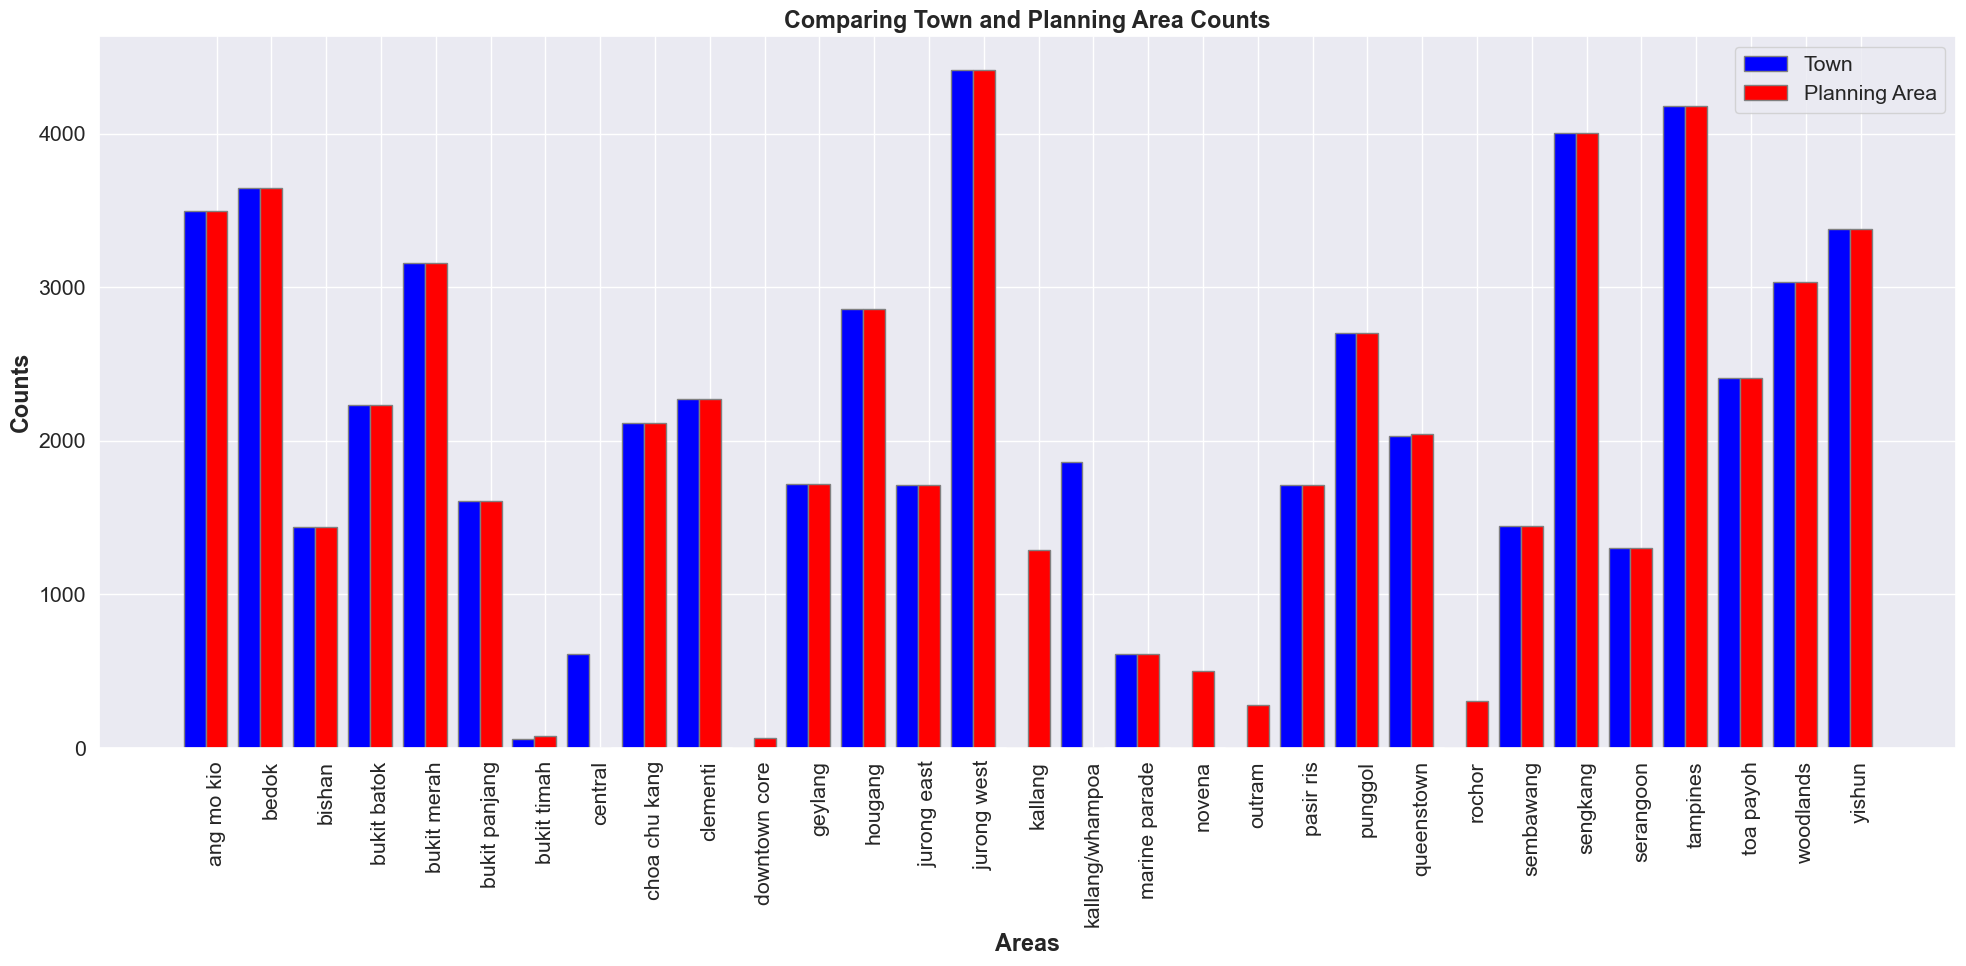

In [8]:
town_counts = train_data['town'].value_counts()
planning_area_counts = train_data['planning_area'].value_counts()

# Merge the two Series into a single DataFrame
combined_df = pd.DataFrame({'Town': town_counts, 'Planning Area': planning_area_counts}).fillna(0)

# Plotting
plt.figure(figsize=(20, 10))

# Width of a bar
width = 0.4

# Positions of bars on x axis
r1 = range(len(combined_df))
r2 = [x + width for x in r1]

# Creating bars
plt.bar(r1, combined_df['Town'], width=width, label='Town', color='blue', edgecolor='grey')
plt.bar(r2, combined_df['Planning Area'], width=width, label='Planning Area', color='red', edgecolor='grey')

# Title & Subtitle
plt.title('Comparing Town and Planning Area Counts', fontweight='bold')

# X axis
plt.xlabel('Areas', fontweight='bold')
plt.xticks([r + width for r in range(len(combined_df))], combined_df.index, rotation=90)

# Y axis
plt.ylabel('Counts', fontweight='bold')

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

#### 1.4 b) flat_type

In [9]:
train_data['flat_type'].value_counts()

flat_type
4 room       21889
3 room       18897
5 room       14759
executive     3528
2 room         927
Name: count, dtype: int64

#### 1.4 c) flat_model

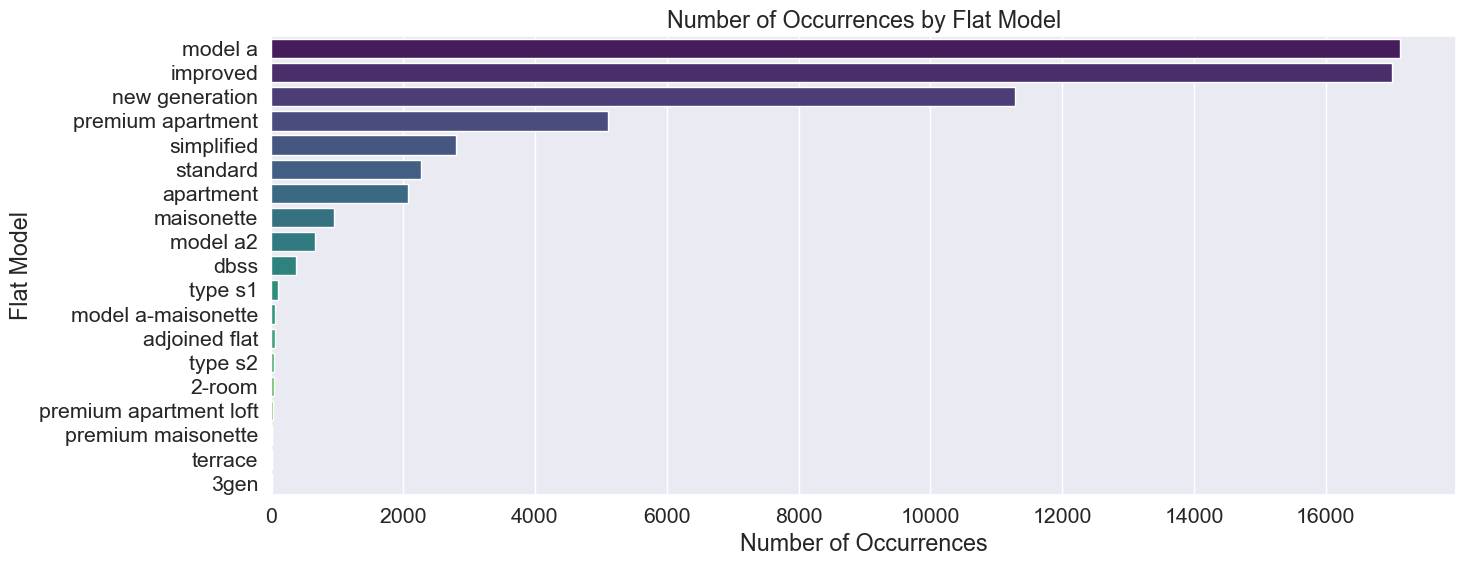

In [10]:
flat_model_counts = train_data['flat_model'].value_counts()

# Plotting
plt.figure(figsize=(15,6))  # Adjust the figure size
sns.barplot(y=flat_model_counts.index, x=flat_model_counts.values, palette='viridis')  # Use y for town names to get a horizontal bar plot

# Add titles and labels
plt.title('Number of Occurrences by Flat Model')
plt.xlabel('Number of Occurrences')
plt.ylabel('Flat Model')

# Display the plot
plt.tight_layout()
plt.show()

In [11]:
train_data['flat_model'].unique()

array(['new generation', 'improved', 'apartment', 'premium apartment',
       'simplified', 'model a', 'standard', 'dbss', 'model a2',
       'maisonette', 'model a-maisonette', 'type s1', 'adjoined flat',
       'type s2', 'premium apartment loft', '2-room',
       'premium maisonette', 'terrace', '3gen'], dtype=object)

#### 1.4 d) furnished

In [12]:
train_data['furnished'].value_counts()

furnished
yes    60000
Name: count, dtype: int64

#### 1.4 e) latitude & longitude


In [13]:
# latitude = train_data['latitude']
# longitude = train_data['longitude']
#
# avg_lat, avg_lon = latitude.mean(), longitude.mean()
#
# # Create a base map
# m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)
#
# # Add the heat map
# heat_data = [[lat, lon] for lat, lon in zip(train_data['latitude'], train_data['longitude'])]
# HeatMap(heat_data).add_to(m)
#
# # Display the map if NEEDED
# # m

#### 1.4 f) subzone

In [14]:
train_data['subzone'].value_counts()

subzone
tampines east             2469
bedok north               1644
jurong west central       1496
woodlands east            1318
punggol field             1203
sengkang town centre      1198
tampines west             1098
yishun west               1094
clementi north            1093
rivervale                  917
yunnan                     867
anchorvale                 837
pasir ris drive            827
hong kah                   814
cheng san                  804
hougang west               779
yishun south               722
yishun east                682
fernvale                   681
yew tee                    681
toa payoh central          669
bedok south                653
waterway east              652
kebun bahru                625
macpherson                 622
chong boon                 620
simei                      616
sembawang central          613
marine parade              612
matilda                    605
taman jurong               595
yuhua east                 593


#### 1.4 g) region

In [15]:
train_data['region'].value_counts()

region
west region          14355
north-east region    14355
central region       13896
east region           9539
north region          7855
Name: count, dtype: int64

#### 1.4 h) block

In [16]:
train_data['block'].value_counts()

block
102     220
34      220
105     204
114     202
108     201
113     199
101     188
109     185
110     182
30      180
22      179
17      179
32      178
112     178
11      177
107     176
115     174
116     174
20      173
23      171
19      171
28      169
117     168
18      168
21      167
130     167
12      162
10      162
13      160
124     158
106     151
211     149
111     147
121     142
157     142
33      141
120     141
103     141
104     141
210     140
304     137
119     136
122     131
204     130
31      129
129     125
45      125
419     125
27      124
128     122
406     122
125     122
44      121
55      120
24      120
202     119
231     118
123     118
35      117
53      115
26      115
52      114
146     114
421     114
534     114
132     114
50      114
16      114
51      113
118     113
161     113
126     113
82      112
303     111
205     109
15      109
214     108
327     107
142     107
229     106
185     106
60      105
232     10

## 1.5 Univariate Analysis - Numerical

#### 1.5 a) monthly_rent statistics

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


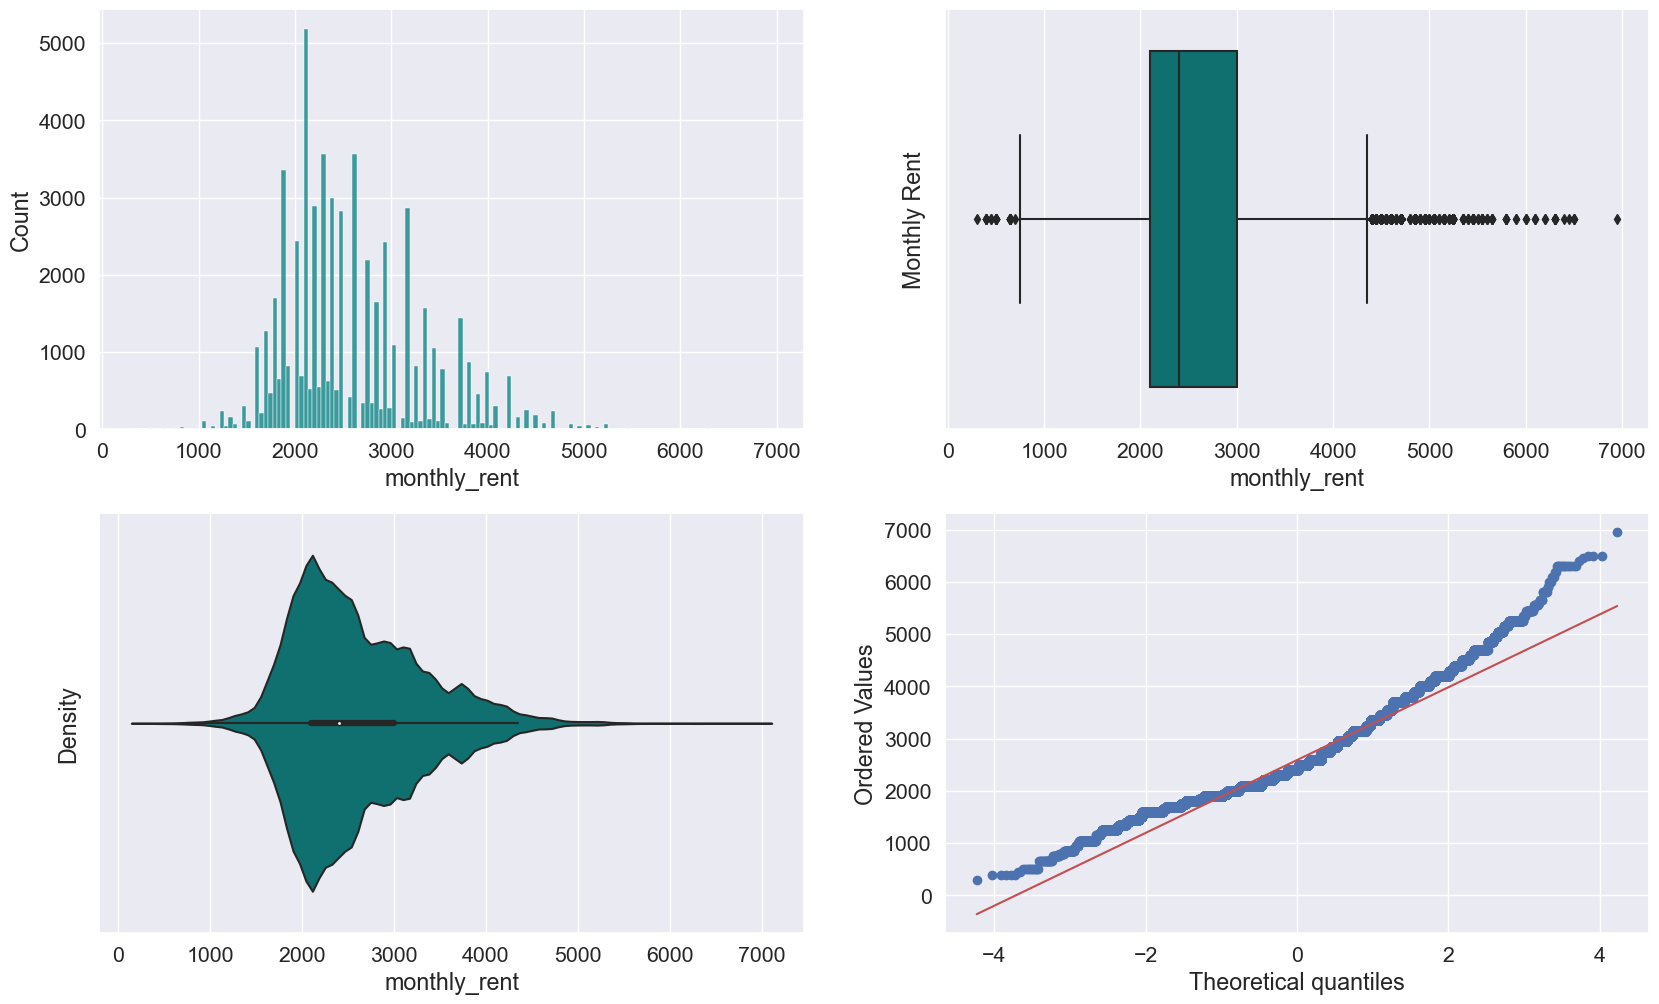

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

# Histogram
ax1 = sns.histplot(x=train_data['monthly_rent'], color='teal', ax=ax[0, 0])
ax1.set_ylabel('Count')  # Adding y-axis label for histogram

# Boxplot
ax2 = sns.boxplot(x=train_data['monthly_rent'], ax=ax[0, 1], color='teal')
ax2.set_ylabel('Monthly Rent')  # Adding y-axis label for boxplot

# Violin Plot
ax3 = sns.violinplot(x=train_data['monthly_rent'], ax=ax[1, 0], color='teal')
ax3.set_ylabel('Density')  # Adding y-axis label for violin plot

# Probability Plot
ax4 = probplot(train_data['monthly_rent'], plot=pylab)
# Remove the title
plt.gca().set_title('')

pylab.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


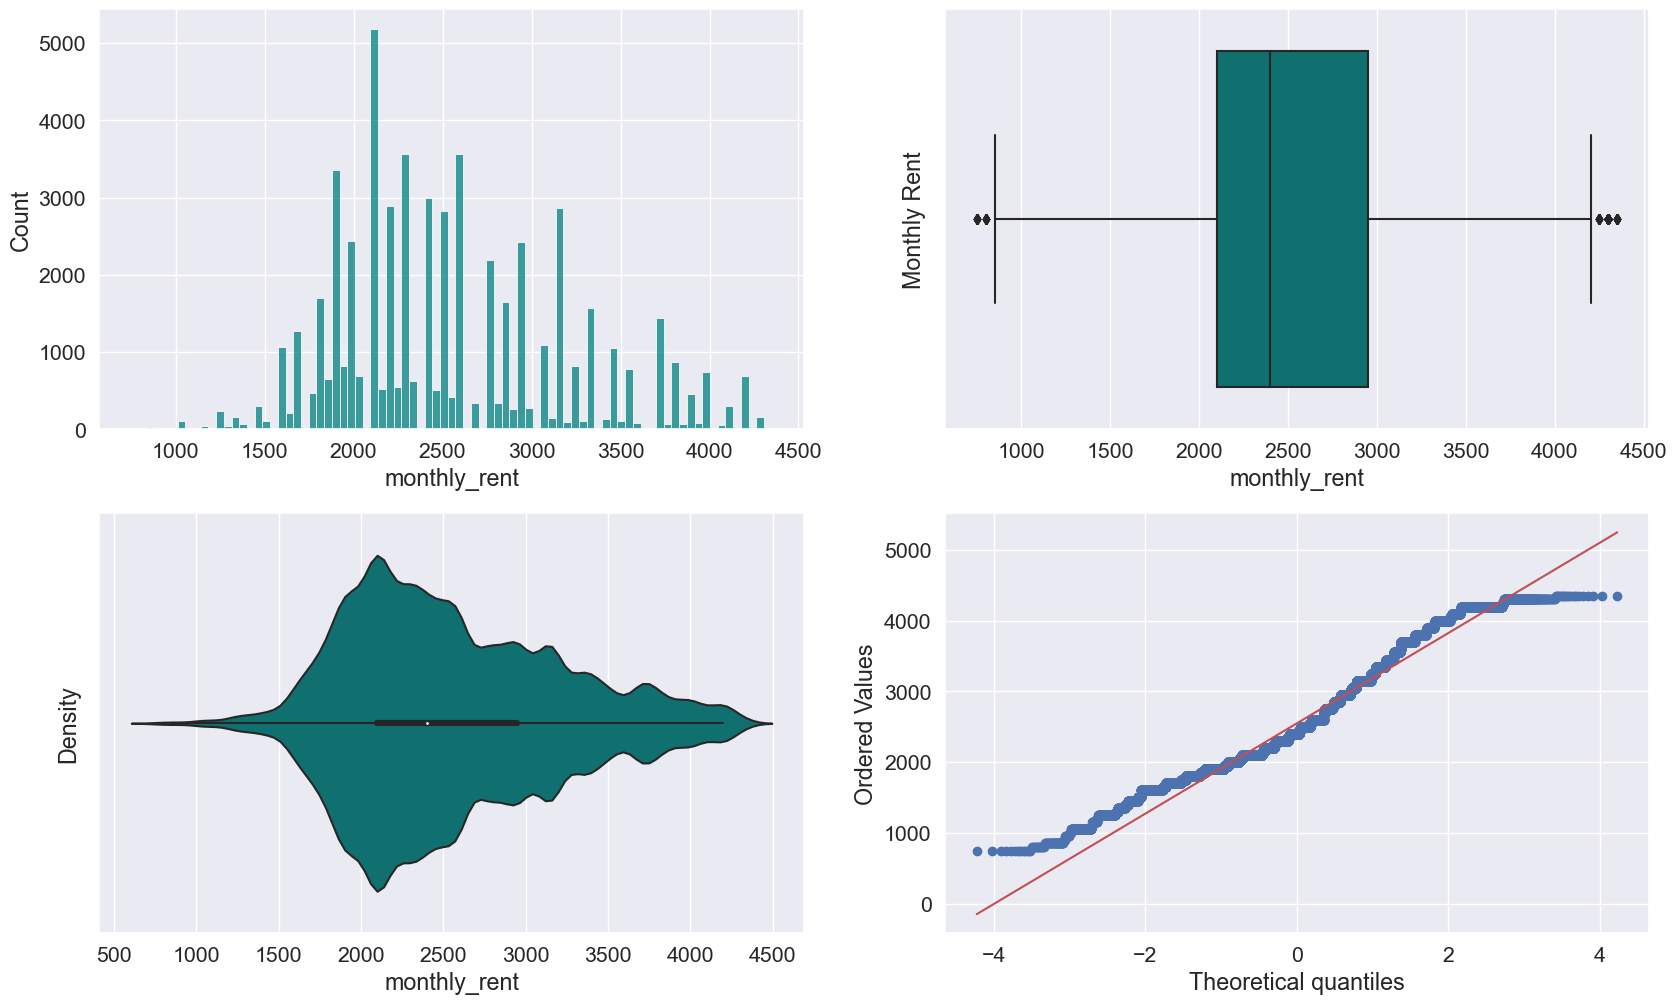

In [18]:
# Interquartile Range (IQR) approach : dealing with rent prices or similar continuous data, you can use various techniques.
Q1 = train_data['monthly_rent'].quantile(0.25)
Q3 = train_data['monthly_rent'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
df_filtered = train_data[(train_data['monthly_rent'] >= lower_bound) & (train_data['monthly_rent'] <= upper_bound)]

# Modified Z-Score Method
# median = train_data['monthly_rent'].median()
# mad = abs(train_data['monthly_rent'] - median).median()
# modified_z_scores = 0.6745 * (train_data['monthly_rent'] - median) / mad
# outliers = (modified_z_scores > 3.5) | (modified_z_scores < -3.5)
# Filter out the outliers
# df_filtered = train_data[~outliers]

fig, ax = plt.subplots(2, 2, figsize=(20, 12))

# Histogram
ax1 = sns.histplot(x=df_filtered['monthly_rent'], color='teal', ax=ax[0, 0])
ax1.set_ylabel('Count')  # Adding y-axis label for histogram

# Boxplot
ax2 = sns.boxplot(x=df_filtered['monthly_rent'], ax=ax[0, 1], color='teal')
ax2.set_ylabel('Monthly Rent')  # Adding y-axis label for boxplot

# Violin Plot
ax3 = sns.violinplot(x=df_filtered['monthly_rent'], ax=ax[1, 0], color='teal')
ax3.set_ylabel('Density')  # Adding y-axis label for violin plot

# Probability Plot
ax4 = probplot(df_filtered['monthly_rent'], plot=pylab)
# Remove the title
plt.gca().set_title('')

pylab.show()

#### 1.5 b) region v.s. monthly_rent

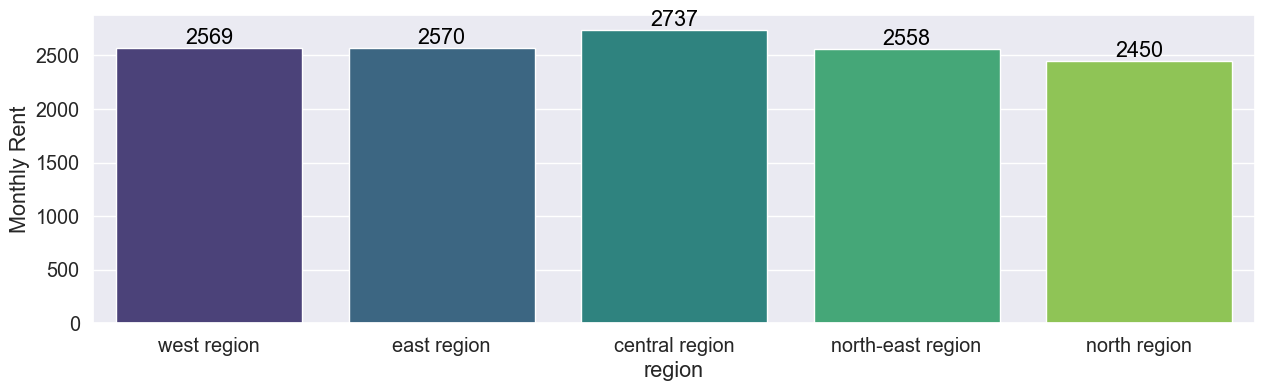

In [19]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=train_data['region'],
                 y=train_data['monthly_rent'],
                 palette=sns.color_palette("viridis", n_colors=len(train_data['region'].unique())),
                 ci=None)
plt.ylabel('Monthly Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha='center', va='bottom', color='Black')


#### 1.5 c) flat_type v.s. monthly_rent

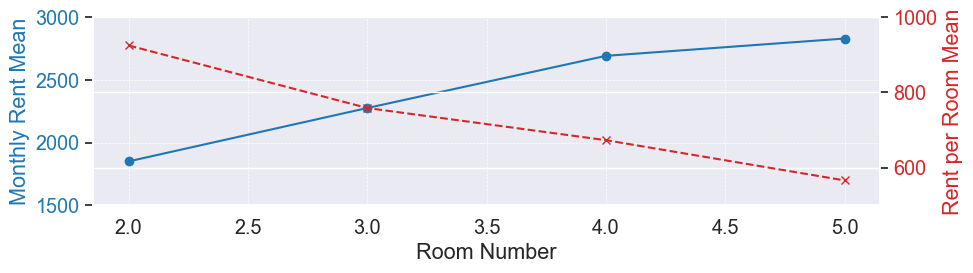

In [20]:
datasets = [train_data, test_data]
for idx, dataset in enumerate(datasets):
    # Replace "executive" with "6-room"
    dataset['flat_type'] = dataset['flat_type'].replace('executive', '5 room')
    # Extract the numeric part and convert it to integer
    dataset['room_num'] = dataset['flat_type'].str.extract('(\d)').astype(int)
    # Update the original datasets
    datasets[idx] = dataset
train_data, test_data = datasets

# Group by room_num to get average rent and average rent per room
grouped_data = train_data.groupby('room_num').agg({
    'monthly_rent': 'mean'
})
grouped_data['rent_per_room'] = grouped_data['monthly_rent'] / grouped_data.index

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 3))  # Adjust the figure size for better visualization

color = 'tab:blue'
ax1.set_xlabel('Room Number')
ax1.set_ylabel('Monthly Rent Mean', color=color)
ax1.plot(grouped_data.index, grouped_data['monthly_rent'], color=color, linestyle='-', marker='o')  # Added markers for clarity
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([1500, 3000])  # Set y-axis limit for ax1 as specified

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Rent per Room Mean', color=color)
ax2.plot(grouped_data.index, grouped_data['rent_per_room'], color=color, linestyle='--', marker='x')  # Different linestyle and markers for distinction
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([500, 1000])  # Set y-axis limit for ax2 as specified

# Add a title and grid for better visualization
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

fig.tight_layout()
plt.show()

#### 1.5 d) flat_model v.s. monthly_rent

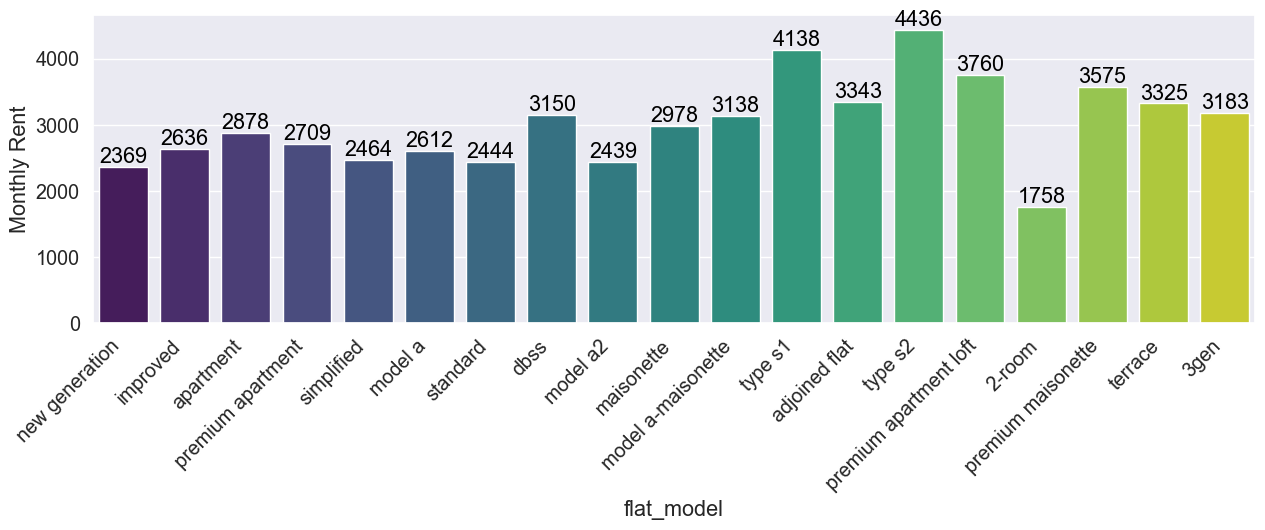

In [21]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=train_data['flat_model'],
                 y=train_data['monthly_rent'],
                 palette='viridis',
                 ci = None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('Monthly Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

#### 1.5 e) house age v.s. monthly_rent

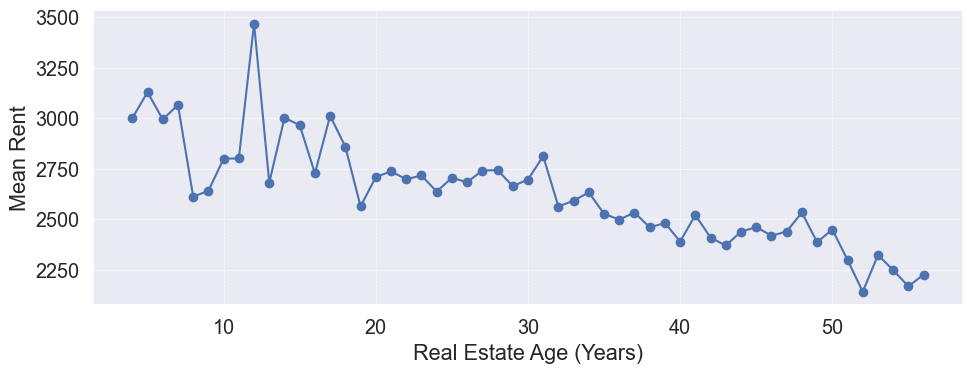

In [22]:
train_data = train_data.sort_values('lease_commence_date')

# Calculate real estate age without modifying the original train_data
age_rent_df = train_data[['lease_commence_date', 'monthly_rent']].copy()
age_rent_df['real_estate_age'] = 2023 - age_rent_df['lease_commence_date']
age_rent_df = age_rent_df[age_rent_df['real_estate_age'] < (2023 - 1966)]
# Group by real estate age and calculate mean rent
grouped_data = age_rent_df.groupby('real_estate_age').agg({
    'monthly_rent': 'mean'
}).reset_index()

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(grouped_data['real_estate_age'], grouped_data['monthly_rent'], marker='o', linestyle='-')
plt.xlabel('Real Estate Age (Years)')
plt.ylabel('Mean Rent')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [23]:
train_data['lease_commence_date'].unique()

array([1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

#### 1.5 f) floor_area_sqm v.s. monthly_rent

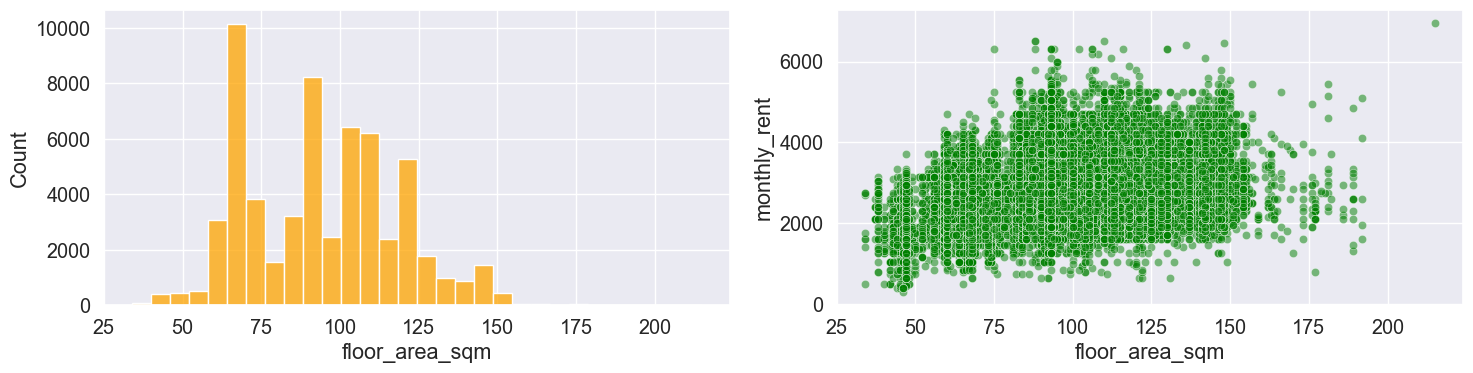

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(train_data['floor_area_sqm'], bins=30, kde=False, color='orange', ax=ax[0])  # Adjust position as desired
sns.scatterplot(x=train_data['floor_area_sqm'], y=train_data['monthly_rent'], ax=ax[1], color='green', alpha=0.5)  # Adjust position as desired

plt.tight_layout()
plt.show()

#### 1.5 g) monthly_rent per sqm

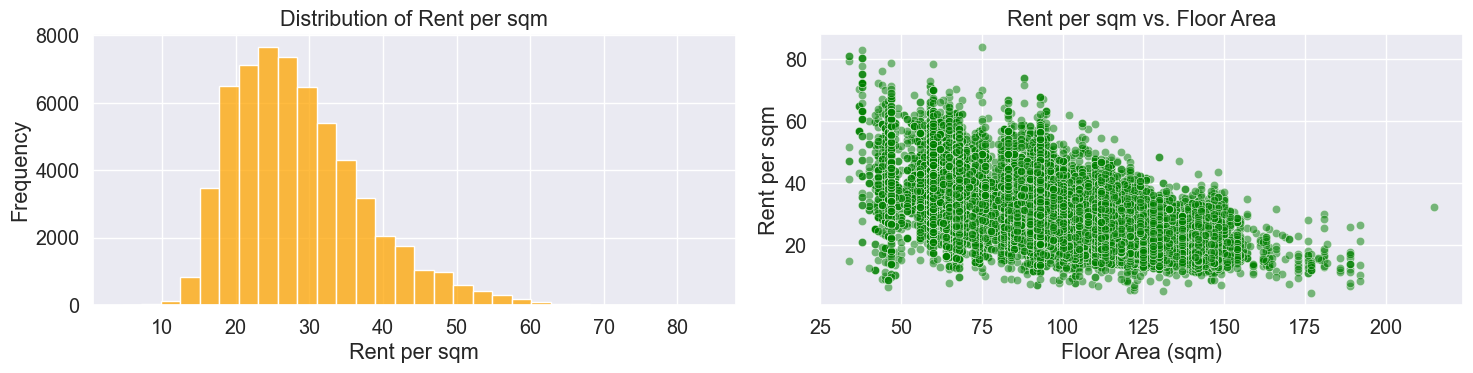

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Left-hand side plot
sns.histplot(train_data['monthly_rent'] / train_data['floor_area_sqm'], bins=30, kde=False, color='orange', ax=ax[0])
ax[0].set_title('Distribution of Rent per sqm')  # Adding a title
ax[0].set_xlabel('Rent per sqm')  # Setting x-label
ax[0].set_ylabel('Frequency')  # Setting y-label

# Right-hand side plot
sns.scatterplot(x=train_data['floor_area_sqm'], y=train_data['monthly_rent'] / train_data['floor_area_sqm'], ax=ax[1], color='green', alpha=0.5)
ax[1].set_title('Rent per sqm vs. Floor Area')  # Adding a title
ax[1].set_xlabel('Floor Area (sqm)')  # Setting x-label
ax[1].set_ylabel('Rent per sqm')  # Setting y-label

plt.tight_layout()
plt.show()

#### 1.5 h) monthly_rent heat map

In [26]:
# Create a base map
zoom_level=12
m = folium.Map(location=[train_data['latitude'].mean(), train_data['longitude'].mean()], zoom_start=zoom_level,
               zoomControl=False, max_zoom=zoom_level, min_zoom=zoom_level, width='100%', height='100%')

# Add the heatmap
heat_data = [[row['latitude'], row['longitude'], row['monthly_rent']] for index, row in train_data.iterrows()]
HeatMap(heat_data).add_to(m)
m

#### 1.5 i) monthly_rent clustering

In [27]:
# # Extract and standardize the longitude and latitude features
# coords = pd.concat([train_data[['longitude', 'latitude']], test_data[['longitude', 'latitude']]])
# coords_scaled = StandardScaler().fit_transform(coords)
# #
# # # DBSCAN clustering
# # dbscan = DBSCAN(eps=0.5, min_samples=12)
# # train_data['dbscan_labels'] = dbscan.fit_predict(coords_scaled)
#
# # K-Means clustering
# kmeans = KMeans(n_clusters=12, random_state=0)
# kmeans.fit(coords_scaled)
# train_data['kmeans_labels'] = kmeans.predict(train_data[['longitude', 'latitude']])
# test_data['kmeans_labels'] = kmeans.predict(test_data[['longitude', 'latitude']])
#
# # Plotting
# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#
# # DBSCAN plot
# # ax[0].scatter(train_data['longitude'], train_data['latitude'], c=train_data['dbscan_labels'], cmap='rainbow', s=50)
# # ax[0].set_title('DBSCAN Clustering')
# # ax[0].set_xlabel('Longitude')
# # ax[0].set_ylabel('Latitude')
#
# # K-Means plot
# ax[1].scatter(train_data['longitude'], train_data['latitude'], c=train_data['kmeans_labels'], cmap='rainbow', s=50)
# ax[1].set_title('K-Means Clustering')
# ax[1].set_xlabel('Longitude')
# ax[1].set_ylabel('Latitude')
#
# plt.tight_layout()
# plt.show()

#### 1.5 j) monthly_rent mean and std

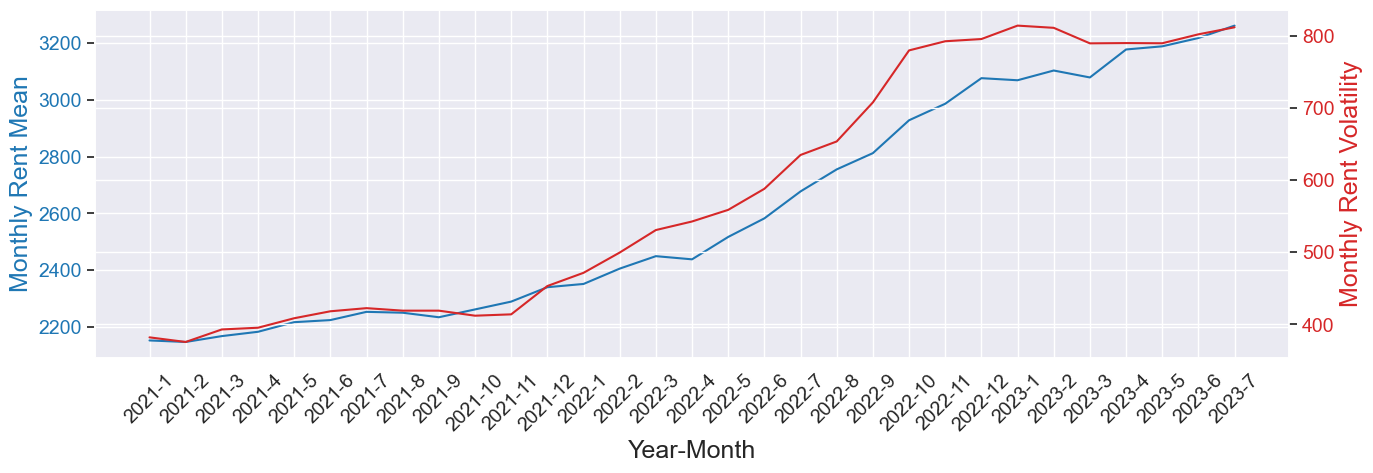

In [28]:
# Copy the original train data to avoid modifying it
split_date = train_data.copy()

# Split the 'rent_approval_date' into separate year and month columns
split_date[['rent_year', 'rent_month']] = split_date['rent_approval_date'].str.split('-', expand=True).astype('int32')

# Group by 'rent_year' and 'rent_month', then calculate mean and standard deviation for 'monthly_rent'
monthly_rent_stats = split_date.groupby(['rent_year', 'rent_month'])['monthly_rent'].agg(
    monthly_rent_mean='mean',
    monthly_rent_volatility='std'
).reset_index()

# Create a 'year_month' column for plotting purposes
monthly_rent_stats['year_month'] = monthly_rent_stats['rent_year'].astype(str) + '-' + monthly_rent_stats['rent_month'].astype(str)

# Create a plot with a twin y-axis
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot the mean of the monthly rent on the primary y-axis
ax1.set_xlabel('Year-Month', fontsize=18)
ax1.set_ylabel('Monthly Rent Mean', color='tab:blue', fontsize=18)
ax1.plot(monthly_rent_stats['year_month'], monthly_rent_stats['monthly_rent_mean'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=14)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Monthly Rent Volatility', color='tab:red', fontsize=18)
ax2.plot(monthly_rent_stats['year_month'], monthly_rent_stats['monthly_rent_volatility'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)

# Title of the plot
# plt.title('Monthly Rent Mean and Volatility Over Time', fontsize=16)

# Show the plot
fig.tight_layout()  # To ensure the subplot fits into the figure area
plt.show()

## 1.6 EDA - Aux Data

#### 1.6 a) coe
* To register a vehicle, you must first bid for a COE.Category refers to different vehicle types. Some background info: https://onemotoring.lta.gov.sg/content/onemotoring/home/buying/upfront-vehicle-costs/certificate-of-entitlement--coe-.html
1. category: Different categories might represent different types of vehicles, such as motorcycles, passenger cars, commercial vehicles, etc.
2. month: the month in which the COE bid took place.
3. bidding: the bidding round or session within the specified month.
4. price: the successful bid price for the COE in that category and bidding session. It represents the cost to obtain the COE.
5. quota: the number of COEs available for bidding in that category and session. It's the supply side of the equation.
6. bids: the number of bids received for the available COEs in that category and session. It's the demand side of the equation.

In [29]:
# Combine 'year' and 'month' into a 'date' column and convert to datetime
coe_price_data['date'] = pd.to_datetime(coe_price_data['year'].astype(str) + ' ' + coe_price_data['month'], format='%Y %B')
coe_price_data.drop(columns=['year','month','bidding'], inplace=True)
coe_price_data.head()

category  price  quota  bids       date
0        a  95202    581   728 2023-07-01
1        a  97000    588   756 2023-07-01
2        a  96206    586   751 2023-06-01
3        a  98001    581   881 2023-06-01
4        a  92000    596   936 2023-05-01

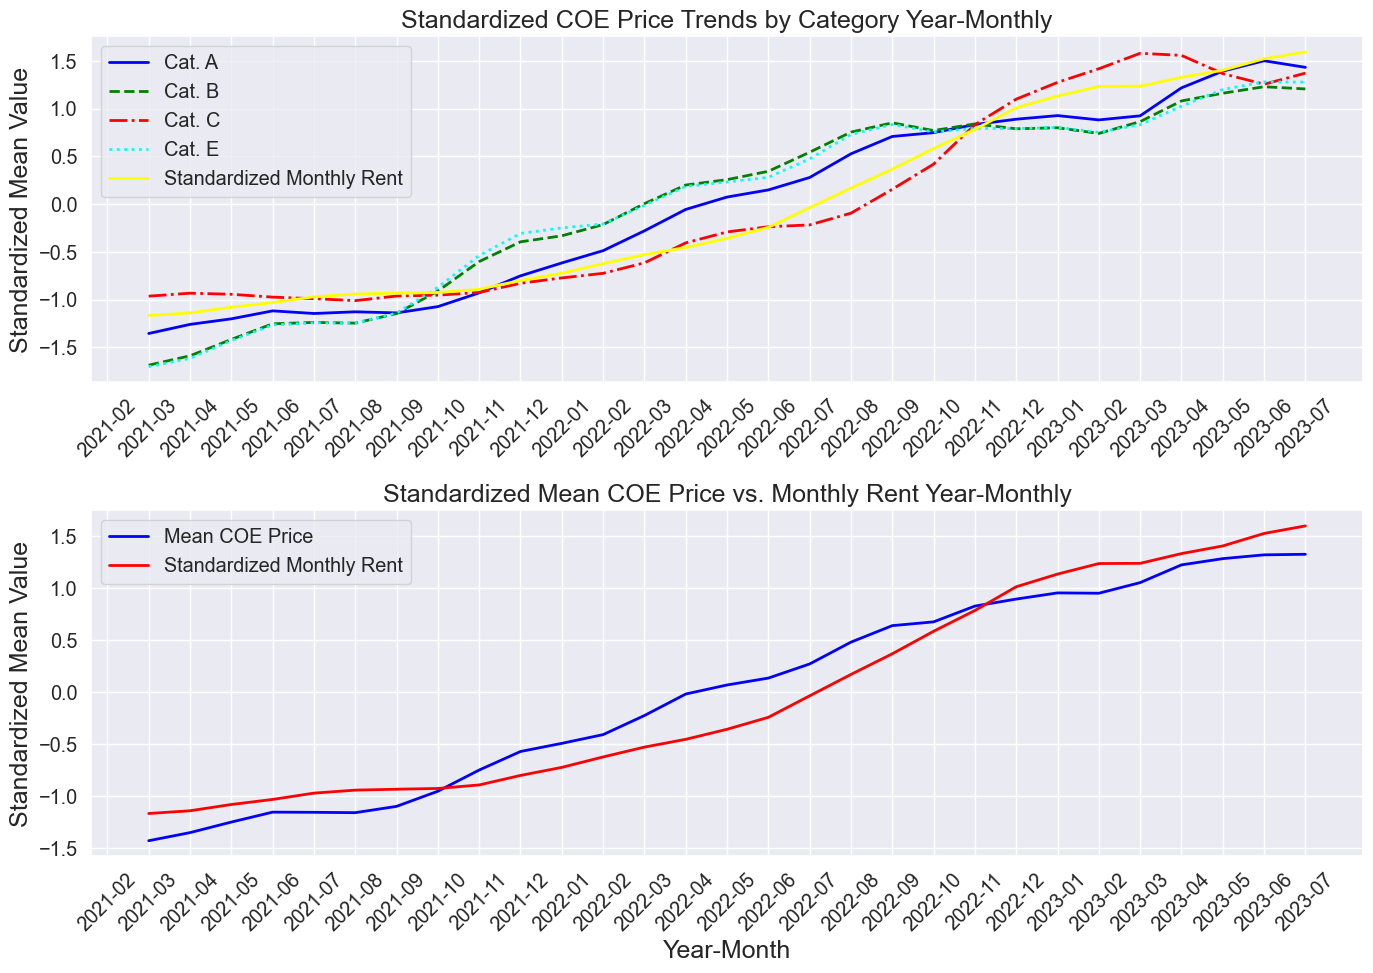

In [30]:
# Convert the "date" column to datetime format if it's not already
coe_price_data['date'] = pd.to_datetime(coe_price_data['date'])

# Extract year and month from the 'date' column
coe_price_data['year'] = coe_price_data['date'].dt.year
coe_price_data['month'] = coe_price_data['date'].dt.month

# Group by 'year', 'month', and 'category', then calculate the mean price
monthly_coe_stats = coe_price_data.groupby(['year', 'month', 'category'])['price'].mean().reset_index()

# Pivot the data to have categories as columns and fill NaNs with the previous value
category_pivot = monthly_coe_stats.pivot_table(index=['year', 'month'], columns='category', values='price').fillna(method='ffill')

# Group by 'rent_year' and 'rent_month', then calculate mean for 'monthly_rent'
monthly_rent_stats = split_date.groupby(['rent_year', 'rent_month'])['monthly_rent'].mean().reset_index()

# Combine the COE categories and rent price into one DataFrame for scaling
combined_stats = category_pivot.reset_index()
combined_stats['rent_price'] = monthly_rent_stats['monthly_rent']

# Standardize the data
scaler = StandardScaler()
combined_stats[['rent_price', 'a', 'b', 'c', 'e']] = scaler.fit_transform(combined_stats[['rent_price', 'a', 'b', 'c', 'e']])

# Create a 'year_month' column for plotting purposes
combined_stats['year_month'] = combined_stats['year'].astype(str) + '-' + combined_stats['month'].apply(lambda x: f'{x:02d}')

# Sort the DataFrame based on 'year_month' to ensure the plot is in chronological order
combined_stats.sort_values('year_month', inplace=True)

# Set the figure size for better readability
plt.figure(figsize=(14, 10))

# First subplot for category-wise COE price trends
plt.subplot(2, 1, 1)
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]
for i, category in enumerate(['a', 'b', 'c', 'e']):
    plt.plot(combined_stats['year_month'], combined_stats[category].rolling(window=3).mean(), label=f'Cat. {category.upper()}', color=colors[i], linestyle=line_styles[i], linewidth=2)
plt.plot(combined_stats['year_month'], combined_stats['rent_price'].rolling(window=3).mean(), color='yellow', label='Standardized Monthly Rent', linewidth=2)
plt.title('Standardized COE Price Trends by Category Year-Monthly', fontsize=18)
# plt.xlabel('Year-Month', fontsize=18)
plt.ylabel('Standardized Mean Value', fontsize=18)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Second subplot for mean COE price vs rent
plt.subplot(2, 1, 2)
plt.plot(combined_stats['year_month'], combined_stats[['a', 'b', 'c','e']].mean(axis=1).rolling(window=3).mean(), color='blue', label='Mean COE Price', linewidth=2)
plt.plot(combined_stats['year_month'], combined_stats['rent_price'].rolling(window=3).mean(), color='red', label='Standardized Monthly Rent', linewidth=2)
plt.title('Standardized Mean COE Price vs. Monthly Rent Year-Monthly', fontsize=18)
plt.xlabel('Year-Month', fontsize=18)
plt.ylabel('Standardized Mean Value', fontsize=18)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### 1.6 b) primary_school
1. singapore primary school choose: https://investingsg.com/keyinfo/schools-properties/. Key points:
* 什么样的房子算学区房？
    * 教育部说了 ”每一所小学都是好学校“。但是，民间排名一直都在。一般意义上是在名校一公里范围内，抽签概率好的学校可以扩大到两公里范围。如果做社区义工还要注意住址和小学是否在同一个GRC。
* 租房租多久，什么时候开始租？
    * 报名是按IC地址，所以没有明确开始租房日期，只要报名时IC地址改了就可以。报名成功后需住满30个月，这项规定同样适用于买的房子。

In [31]:
primary_school_data.head()

name  latitude   longitude
0      Admiralty Primary School  1.454038  103.817436
1  Ahmad Ibrahim Primary School  1.433153  103.832942
2                Ai Tong School  1.360583  103.833020
3      Alexandra Primary School  1.291334  103.824425
4   Anchor Green Primary School  1.390370  103.887165

#### 1.6 c) mall

In [32]:
mall_data.head()

name  latitude   longitude
0                          100 AM  1.274588  103.843471
1                    313@Somerset  1.301385  103.837684
2                          Aperia  1.310867  103.863930
3  Balestier Hill Shopping Centre  1.325596  103.842572
4                      Bugis Cube  1.298141  103.855635

#### 1.6 d) mrt_planned
* https://www.propertyguru.com.sg/property-guides/mrt-effect-on-property-prices-39498
   * 0.3 KM: MRT-house
    * 1KM: MRT-near-house

In [33]:
mrt_planned_data.head()

code                name opening_year  latitude   longitude
2   NaN       Punggol Coast         2024  1.415280  103.911110
4   NaN              Keppel         2026  1.270100  103.831000
5   NaN          Cantonment         2026  1.272814  103.836659
6   NaN  Prince Edward Road         2026  1.273254  103.847298
8   NaN                Hume         2025  1.354650  103.769040

#### 1.6 e) mrt_exist

In [34]:
mrt_exist_data.head()

code           name  opening_year  latitude   longitude
0  NS1    Jurong East          1990  1.333295  103.742154
1  NS2    Bukit Batok          1990  1.349035  103.749526
2  NS3   Bukit Gombak          1990  1.358663  103.751913
3  NS4  Choa Chu Kang          1990  1.385363  103.744371
4  NS5        Yew Tee          1996  1.397476  103.747418

#### 1.7 f) stock_prices

In [35]:
stock_price_data['name'].value_counts()

name
Triterras                                647
Grab Holdings                            647
Kulicke and Soffa Industries             647
Maxeon Solar Technologies                647
Flex                                     647
Kenon Holdings                           647
ASLAN Pharmaceuticals                    647
Sea (Garena)                             647
Grindrod Shipping                        647
Wave Life Sciences                       647
Pacific Century Regional Developments    646
CapitaLand Ascott Trust                  646
OCBC Bank                                646
SATS                                     646
Suntec REIT                              646
NetLink Trust                            646
Keppel REIT                              646
ComfortDelGro                            646
Singapore Land                           646
Golden Agri-Resources                    646
HPH Trust (Hutchison Port)               646
Olam                                     646
Yanlo

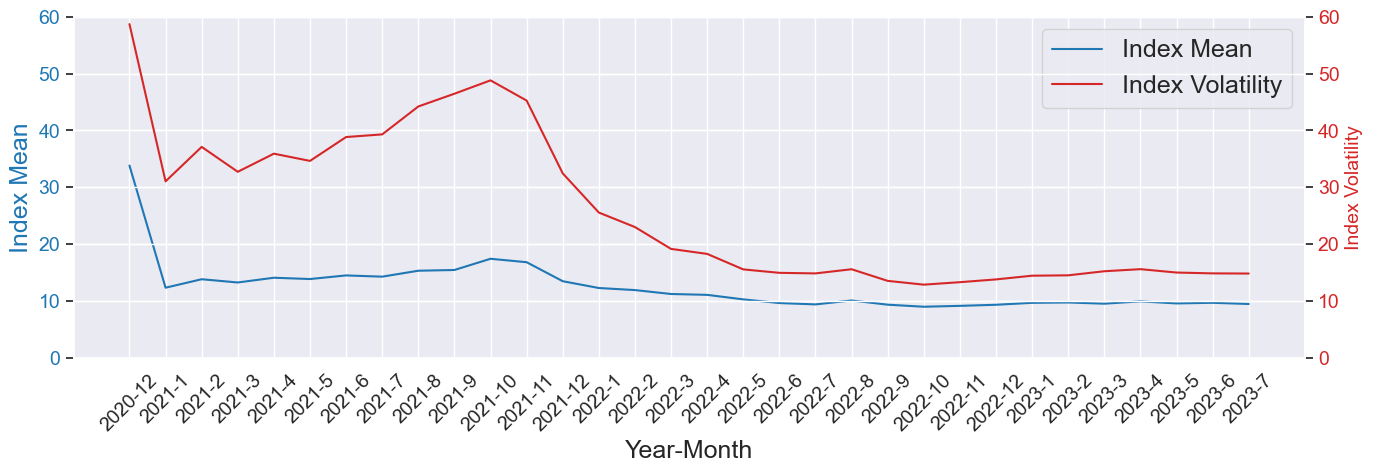

In [36]:
# remove illiquid stocks
mask = stock_price_data['name'].transform(lambda x: stock_price_data['name'].value_counts()[x] >= 100)
liquid_stock_price_data = stock_price_data[mask]

# compute monthly statistics
monthly_stats = get_economic_indicator_feature(liquid_stock_price_data, 'stock', 'adjusted_close')

# Create a new column 'year_month' for plotting purposes
monthly_stats['year_month'] = monthly_stats['year'].astype(str) + '-' + monthly_stats['month'].astype(str)

# Explicitly create a figure and set the size
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot the mean of the index on the primary y-axis
ax1.set_xlabel('Year-Month', fontsize=18)
ax1.set_ylabel('Index Mean', color='tab:blue', fontsize=18)
ax1.set_ylim(0,60)
line1 = ax1.plot(monthly_stats['year_month'], monthly_stats['index_price'], color='tab:blue', label='Index Mean')
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=14)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylim(0,60)
ax2.set_ylabel('Index Volatility', color='tab:red', fontsize=14)
line2 = ax2.plot(monthly_stats['year_month'], monthly_stats['index_volatility'], color='tab:red', label='Index Volatility')
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)

# Title of the plot
# plt.title('Index Mean and Volatility Over Time')

# Combine the legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0, fontsize=18)

# Adjust the layout and show the plot
fig.tight_layout()
plt.show()

## 1.8 Observation - Main Data
1. monthly rent
* it's not heavily skewed, but there are definately outliers
* regions - the average rent across different regions are roughly the same
* flat_type - the average rent is positively correlated to the #room
* flat_model - those with extremely low frequency in flat_model usually have a high price
* lease_commence_date - graph indicates the rent is increasing yearly, and exhibit up and downs in each decade. this can be combined with the auxiliary data to analyze the influence of economics
* latitude&longitude - observe from a higher angle, there are definately groups

2. region
* the rent data across regions varies less than 1%, this feature is providing very limited infomation

3. town & planning_area
* these two features' value overlaps, and there are 3 extra values in planning_area. binary encoded with other geographical features?
4. flat_type
* 4/3/5 rooms are most popular, does that mean sufficient demand or supply? (may influence price)
5. furnished
* 100% furnished, can we drop this feature?
6. latitude & longitude
* there are actually naturally formed groups, how to group them properly?
7. subzone
* maybe can be used with the latitude * longitude?
8. block
* What is block_NO: https://www.quora.com/Why-did-Singapore-start-having-HDB-block-numbers-with-letters-e-g-172A-B-C
* To sum up: each number is a location, and the following letter is the age. However, we have location & lease date info, thus drop this
9. Rent/SQM
* the distribution shows a significant pattern compared to seperated; thus we should include this feature in FE
10. Grouping
* According to the heatmap, there are 12 natural groups.


## 1.9 Observation - Aux Data
1. coe_price_data
* figure out whether the COE is a lagging or not. More specifically, different types of COE may vary. Main focus should be on Category_C: Goods vehicle&bus, and Category_D: Motorcycle v.s. Category_A and Category_B. The former are used as productivity materials, while the latter is consumption.
2. primary_school_data
* for each school, find its KNN house, and statistics w.r.t rent: 1km_school_rent_mean, 1km_school_rent_median, 2km_school_rent_mode, ...;
* for each record, find all primary_schools within 1km, 2km range, and average out the statistics before-mentioned.
3. mall
* for each mall, find its KNN house, and the statistics: mall_average_rent, mall_median_rent, mall_75_rent, mall_25_rend;
* for each record, find the malls within 3km range, and average out the statistics before-mentioned.
4. mrt_planned
* for each record, find the #mrt_planned within 0.3KM and 1KM, with those beyond 3 years ones ignored.
5. mrt_exist
* for each record, find the #mrt_planned within 0.3KM and 1KM.
6. stock_price
* stock_price is a leading indicator of economics, while rent_price is lagging indicator. This relationship implies that stock_price can be used to predict the overall rent price.
* stock_price includes 59 stocks, thus we can form an index, and compute the index value on each trading day. However, those extremely illiquid stocks should be removed.
* Time-Series-Regression can have some weight in the final model.

# 2. Preprocessing
## 2.1 Eliminate Redundant Information

In [37]:
# block: drop this feature, refer to EDA observations
# furnished: the value of this attribute for all data is "yes"
# elevation: Similar to attribute "furnished"
# region: drop this feature, refer to EDA observations
dropped_features = ['furnished', 'elevation', 'region', 'block']

datasets = [train_data, test_data]
for idx, dataset in enumerate(datasets):
    dataset.drop(columns=dropped_features, inplace=True)

train_data.head()

rent_approval_date         town block         street_name flat_type  \
48836            2023-01  jurong east    38  teban gardens road    3 room   
12177            2022-07   queenstown    82  commonwealth close    3 room   
18295            2021-07      geylang    64        Circuit Road    3 room   
30958            2021-07    toa payoh   112  Lorong 1 Toa Payoh    3 room   
11420            2021-02   queenstown    82  commonwealth close    2 room   

      flat_model  floor_area_sqm  lease_commence_date  latitude   longitude  \
48836   improved            67.0                 1966  1.321073  103.743007   
12177   standard            60.0                 1967  1.304221  103.800400   
18295   standard            59.0                 1967  1.326984  103.887148   
30958   improved            65.0                 1967  1.341553  103.845490   
11420   standard            46.0                 1967  1.304221  103.800400   

              subzone planning_area  monthly_rent  room_num  
48836   teban gardens   jurong east          2950         3  
12177    commonwealth    queenstown          2250         3  
18295      macpherson       geylang          2100         3  
30958  toa payoh west     toa payoh          2100         3  
11420    commonwealth    queenstown          1450         2

## 2.2 Remove Outlier

#### 2.2 a) lease_commence_date Outliers

In [38]:
train_data = train_data[train_data['lease_commence_date'] >1966]

#### 2.2 b) monthly_rent Outliers

In [39]:
# Interquartile Range (IQR) approach : dealing with rent prices or similar continuous data, you can use various techniques.
Q1 = train_data['monthly_rent'].quantile(0.25)
Q3 = train_data['monthly_rent'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.8 * IQR
upper_bound = Q3 + 1.8 * IQR
# Filter out the outliers
train_data = train_data[(train_data['monthly_rent'] >= lower_bound) & (train_data['monthly_rent'] <= upper_bound)].reset_index(drop=True)

## 2.3 Reformat Feature Values

In [40]:
cat_features = ['town', 'street_name', 'subzone', 'flat_model', 'planning_area']
datasets = [train_data, test_data]
for idx, dataset in enumerate(datasets):
    for feature in cat_features:
        dataset[feature] = dataset[feature].str.lower()

train_data.head()

rent_approval_date        town block         street_name flat_type  \
0            2022-07  queenstown    82  commonwealth close    3 room   
1            2021-07     geylang    64        circuit road    3 room   
2            2021-07   toa payoh   112  lorong 1 toa payoh    3 room   
3            2021-02  queenstown    82  commonwealth close    2 room   
4            2022-04     geylang    19          balam road    3 room   

  flat_model  floor_area_sqm  lease_commence_date  latitude   longitude  \
0   standard            60.0                 1967  1.304221  103.800400   
1   standard            59.0                 1967  1.326984  103.887148   
2   improved            65.0                 1967  1.341553  103.845490   
3   standard            46.0                 1967  1.304221  103.800400   
4   standard            60.3                 1967  1.331424  103.887410   

          subzone planning_area  monthly_rent  room_num  
0    commonwealth    queenstown          2250         3  
1      macpherson       geylang          2100         3  
2  toa payoh west     toa payoh          2100         3  
3    commonwealth    queenstown          1450         2  
4      macpherson       geylang          1350         3


# 3. Feature Engineering
1. Binning of numerical variables - https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/discussion/32116
2. create new features by encoding categorical variables using statistics (like mean, median, standard deviation, etc.) of continuous variables. https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/discussion/32123

### 3.1 Synergistically Combined Features

#### 3.1 a) Date Related Features
1. lease_commence_date -> real_estate_age
2. rent_approval_date -> rent_year, rent_month

In [41]:
datasets = [train_data, test_data]

for idx, dataset in enumerate(datasets):
    # lease_commence_date -> real_estate_age
    dataset['real_estate_age'] = 2023 - dataset['lease_commence_date']

    # rent_approval_date -> rent_year, rent_month
    split_date = dataset['rent_approval_date'].str.split('-')
    dataset['rent_year'] = split_date.str[0].astype('int32')
    dataset['rent_month'] = split_date.str[1].astype('int32')

    dataset.drop(columns=['rent_approval_date'], inplace=True)
    dataset.drop(columns=['lease_commence_date'], inplace=True)

    # Update the original datasets
    datasets[idx] = dataset

train_data, test_data = datasets

train_data[:5]

town block         street_name flat_type flat_model  floor_area_sqm  \
0  queenstown    82  commonwealth close    3 room   standard            60.0   
1     geylang    64        circuit road    3 room   standard            59.0   
2   toa payoh   112  lorong 1 toa payoh    3 room   improved            65.0   
3  queenstown    82  commonwealth close    2 room   standard            46.0   
4     geylang    19          balam road    3 room   standard            60.3   

   latitude   longitude         subzone planning_area  monthly_rent  room_num  \
0  1.304221  103.800400    commonwealth    queenstown          2250         3   
1  1.326984  103.887148      macpherson       geylang          2100         3   
2  1.341553  103.845490  toa payoh west     toa payoh          2100         3   
3  1.304221  103.800400    commonwealth    queenstown          1450         2   
4  1.331424  103.887410      macpherson       geylang          1350         3   

   real_estate_age  rent_year  rent_month  
0               56       2022           7  
1               56       2021           7  
2               56       2021           7  
3               56       2021           2  
4               56       2022           4

#### 3.1 b) Rent per Square Meter (DOUBT)
1. lease_commence_date -> real_estate_age
2. rent_approval_date -> rent_year, rent_month

In [42]:
# # Calculate rent per square meter
# train_data['rent_per_sqm'] = train_data['monthly_rent'] / train_data['floor_area_sqm']
# test_data['rent_per_sqm'] = test_data['monthly_rent'] / test_data['floor_area_sqm']
#
# train_data[:5]

#### 3.1 c) Room Num

In [43]:
datasets = [train_data, test_data]
for idx, dataset in enumerate(datasets):
    # Replace "executive" with "6-room"
    dataset['flat_type'] = dataset['flat_type'].replace('executive', '6 room')
    # Extract the numeric part and convert it to integer
    dataset['room_num'] = dataset['flat_type'].str.extract('(\d)').astype(int)
    # Update the original datasets
    datasets[idx] = dataset
train_data, test_data = datasets
train_data[:5]

town block         street_name flat_type flat_model  floor_area_sqm  \
0  queenstown    82  commonwealth close    3 room   standard            60.0   
1     geylang    64        circuit road    3 room   standard            59.0   
2   toa payoh   112  lorong 1 toa payoh    3 room   improved            65.0   
3  queenstown    82  commonwealth close    2 room   standard            46.0   
4     geylang    19          balam road    3 room   standard            60.3   

   latitude   longitude         subzone planning_area  monthly_rent  room_num  \
0  1.304221  103.800400    commonwealth    queenstown          2250         3   
1  1.326984  103.887148      macpherson       geylang          2100         3   
2  1.341553  103.845490  toa payoh west     toa payoh          2100         3   
3  1.304221  103.800400    commonwealth    queenstown          1450         2   
4  1.331424  103.887410      macpherson       geylang          1350         3   

   real_estate_age  rent_year  rent_month  
0               56       2022           7  
1               56       2021           7  
2               56       2021           7  
3               56       2021           2  
4               56       2022           4

#### 3.1 d) Rent per Room (DOUBT)

In [44]:
datasets = [train_data, test_data]
for idx, dataset in enumerate(datasets):
    # dataset['rent_per_room'] = dataset['monthly_rent']/dataset['room_num']
    # dataset = encode_drop(dataset, 'flat_type')
    dataset.drop(columns=['flat_type'], inplace=True)
    datasets[idx] = dataset
train_data, test_data = datasets

train_data[:5]

town block         street_name flat_model  floor_area_sqm  latitude  \
0  queenstown    82  commonwealth close   standard            60.0  1.304221   
1     geylang    64        circuit road   standard            59.0  1.326984   
2   toa payoh   112  lorong 1 toa payoh   improved            65.0  1.341553   
3  queenstown    82  commonwealth close   standard            46.0  1.304221   
4     geylang    19          balam road   standard            60.3  1.331424   

    longitude         subzone planning_area  monthly_rent  room_num  \
0  103.800400    commonwealth    queenstown          2250         3   
1  103.887148      macpherson       geylang          2100         3   
2  103.845490  toa payoh west     toa payoh          2100         3   
3  103.800400    commonwealth    queenstown          1450         2   
4  103.887410      macpherson       geylang          1350         3   

   real_estate_age  rent_year  rent_month  
0               56       2022           7  
1               56       2021           7  
2               56       2021           7  
3               56       2021           2  
4               56       2022           4

### 3.2 Neighboring Facilities Features

#### 3.2 a) "Eigenvector Centrality" Statistics
* for each record of each aux-data: find its KNN houses and calculate statistics
* for each house, find its KNN aux-record, and weighted-average their statistics

In [45]:
# def weighted_avg(values, weights):
#     """Compute the weighted average of values."""
#     return np.dot(values, weights) / weights.sum()
#
# def get_knn_statistics(base_data, aux_data, k):
#     """Compute KNN statistics for given datasets."""
#
#     # Convert latitude and longitude to radians for haversine metric
#     base_data_rad = np.radians(base_data[['latitude', 'longitude']])
#     aux_data_rad = np.radians(aux_data[['latitude', 'longitude']])
#
#     # Initialize KNN
#     knn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric='haversine')
#
#     # Fit and find KNN houses for each record in aux_data
#     knn.fit(base_data_rad)
#     distances, indices = knn.kneighbors(aux_data_rad)
#     distances += 1e-10
#
#     aux_data['median_rent'] = [base_data.iloc[ind]['floor_area_sqm'].median() for ind in indices]
#     aux_data['std_rent'] = [base_data.iloc[ind]['floor_area_sqm'].std() for ind in indices]
#     aux_data['weighted_mean_rent'] = [weighted_avg(base_data.iloc[ind]['floor_area_sqm'], 1/dist) for ind, dist in zip(indices, distances)]
#
#     # Fit and find KNN aux-records for each rent in the base_data
#     knn = NearestNeighbors(n_neighbors=5)
#     knn.fit(aux_data[['latitude', 'longitude']])
#     distances, indices = knn.kneighbors(base_data[['latitude', 'longitude']])
#
#     stats = {
#         'weighted_mean_distance': [weighted_avg(aux_data.iloc[ind]['weighted_mean_rent'], 1/dist) for ind, dist in zip(indices, distances)],
#         'median_distance': [weighted_avg(aux_data.iloc[ind]['median_rent'], 1/dist) for ind, dist in zip(indices, distances)],
#         'std_distance': [weighted_avg(aux_data.iloc[ind]['std_rent'], 1/dist) for ind, dist in zip(indices, distances)]
#     }
#
#     return stats
#
# # Process datasets
# datasets = [train_data, test_data]
aux_datasets = {"school": primary_school_data,
                "mrt_plan": mrt_exist_data,
                "mrt_exist": mrt_exist_data,
                "mall": mall_data}
# k_values = {"school": 20,
#                 "mrt_plan": 5,
#                 "mrt_exist": 5,
#                 "mall": 20}
#
# for idx, dataset in enumerate(datasets):
#     for key, aux_df in aux_datasets.items():
#         k = k_values.get(key)
#         stats = get_knn_statistics(dataset, aux_df, k)
#
#         dataset[f'{key}_median_distance'] = stats['median_distance']
#         dataset[f'{key}_std_distance'] = stats['std_distance']
#         dataset[f'{key}_weighted_mean_distance'] = stats['weighted_mean_distance']
#
#     # Update the original datasets
#     datasets[idx] = dataset
#
# train_data, test_data = datasets
# train_data.head()

#### 3.2 b) Lifecycle Facility Counts
* compute the trans-cycles according to the gov plan
    * MRT: 0.3 KM  MRT-house, 1KM: MRT-near-house
    * Primary School: not explicit data, assume the 15min driving cycle of a school bus, 5KM
    * Mall: 15min driving cycle, approximately 8KM

In [46]:
from sklearn.neighbors import NearestNeighbors

def count_nearby_records(base_data, aux_data, radius):
    """Count the number of nearby records within a specified radius."""

    # Convert latitude and longitude to radians for haversine metric
    base_data_rad = np.radians(base_data[['latitude', 'longitude']])
    aux_data_rad = np.radians(aux_data[['latitude', 'longitude']])

    # Initialize KNN
    knn = NearestNeighbors(algorithm='ball_tree', metric='haversine')
    knn.fit(aux_data_rad)

    # Find records within the specified radius
    indices = knn.radius_neighbors(base_data_rad, radius=radius/6371.0, return_distance=False)  # radius/6371.0 to convert km to radians

    # Count the number of records within the radius for each main record
    counts = [len(ind) for ind in indices]

    return counts

# Define radii for each auxiliary dataset
radii = {
    "school": 5.0,  # 5 km
    "mrt_adjacent": 0.3,  # 0.3 km
    "mrt_nearby": 1.0,  # 1 km
    "mall": 8.0  # 8 km
}

# Process datasets
datasets = [train_data, test_data]
aux_datasets = {"school": primary_school_data,
                "mrt_plan": mrt_exist_data,
                "mrt_exist": mrt_exist_data,
                "mall": mall_data}

for idx, dataset in enumerate(datasets):
    dataset[f'school_count'] = count_nearby_records(dataset, aux_datasets["school"], radii["school"])
    dataset[f'mall_count'] = count_nearby_records(dataset, aux_datasets["mall"], radii["mall"])

    # For MRT stations
    for mrt_key in ["mrt_plan", "mrt_exist"]:
        for radius_key in ["mrt_adjacent", "mrt_nearby"]:
            col_name = f'{mrt_key}_{radius_key}_count'
            dataset[col_name] = count_nearby_records(dataset, aux_datasets[mrt_key], radii[radius_key])

    # Update the original datasets
    datasets[idx] = dataset

train_data, test_data = datasets
train_data[:5]

town block         street_name flat_model  floor_area_sqm  latitude  \
0  queenstown    82  commonwealth close   standard            60.0  1.304221   
1     geylang    64        circuit road   standard            59.0  1.326984   
2   toa payoh   112  lorong 1 toa payoh   improved            65.0  1.341553   
3  queenstown    82  commonwealth close   standard            46.0  1.304221   
4     geylang    19          balam road   standard            60.3  1.331424   

    longitude         subzone planning_area  monthly_rent  room_num  \
0  103.800400    commonwealth    queenstown          2250         3   
1  103.887148      macpherson       geylang          2100         3   
2  103.845490  toa payoh west     toa payoh          2100         3   
3  103.800400    commonwealth    queenstown          1450         2   
4  103.887410      macpherson       geylang          1350         3   

   real_estate_age  rent_year  rent_month  school_count  mall_count  \
0               56       2022           7            21          84   
1               56       2021           7            35          99   
2               56       2021           7            37         101   
3               56       2021           2            21          84   
4               56       2022           4            40         101   

   mrt_plan_mrt_adjacent_count  mrt_plan_mrt_nearby_count  \
0                            0                          1   
1                            0                          4   
2                            1                          3   
3                            0                          1   
4                            0                          4   

   mrt_exist_mrt_adjacent_count  mrt_exist_mrt_nearby_count  
0                             0                           1  
1                             0                           4  
2                             1                           3  
3                             0                           1  
4                             0                           4

#### 3.2 c) Min Distance to Facilities

In [47]:
def haversine_distance_rad(lat1, lon1, lat2, lon2):
    """
    Calculate the haversine distance between two sets of latitude and longitude coordinates in radians.
    """
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

datasets = [train_data, test_data]
aux_datasets = {"school": primary_school_data,
                "mrt_plan": mrt_exist_data,
                "mrt_exist": mrt_exist_data,
                "mall": mall_data}

# For each auxiliary dataset, compute the minimum distance to each record in train_data and test_data
for aux_name, aux_data in aux_datasets.items():
    # Convert latitude and longitude to radians for haversine metric
    aux_data_rad = np.radians(aux_data[['latitude', 'longitude']])

    for dataset in datasets:
        distances = []
        base_data_rad = np.radians(dataset[['latitude', 'longitude']])

        for index, row in base_data_rad.iterrows():
            # Calculate distance from current record to all records in the auxiliary dataset
            dist = haversine_distance_rad(row['latitude'], row['longitude'], aux_data_rad['latitude'].values, aux_data_rad['longitude'].values)
            # Append the minimum distance to the distances list
            distances.append(dist.min())

        # Add the minimum distances as a new feature to the dataset
        dataset[f'min_distance_to_{aux_name}'] = distances

train_data.head()

town block         street_name flat_model  floor_area_sqm  latitude  \
0  queenstown    82  commonwealth close   standard            60.0  1.304221   
1     geylang    64        circuit road   standard            59.0  1.326984   
2   toa payoh   112  lorong 1 toa payoh   improved            65.0  1.341553   
3  queenstown    82  commonwealth close   standard            46.0  1.304221   
4     geylang    19          balam road   standard            60.3  1.331424   

    longitude         subzone planning_area  monthly_rent  ...  school_count  \
0  103.800400    commonwealth    queenstown          2250  ...            21   
1  103.887148      macpherson       geylang          2100  ...            35   
2  103.845490  toa payoh west     toa payoh          2100  ...            37   
3  103.800400    commonwealth    queenstown          1450  ...            21   
4  103.887410      macpherson       geylang          1350  ...            40   

   mall_count  mrt_plan_mrt_adjacent_count  mrt_plan_mrt_nearby_count  \
0          84                            0                          1   
1          99                            0                          4   
2         101                            1                          3   
3          84                            0                          1   
4         101                            0                          4   

   mrt_exist_mrt_adjacent_count  mrt_exist_mrt_nearby_count  \
0                             0                           1   
1                             0                           4   
2                             1                           3   
3                             0                           1   
4                             0                           4   

   min_distance_to_school  min_distance_to_mrt_plan  \
0                0.510196                  0.995405   
1                0.548288                  0.318274   
2                0.503682                  0.213885   
3                0.510196                  0.995405   
4                0.783783                  0.426474   

   min_distance_to_mrt_exist  min_distance_to_mall  
0                   0.995405              0.871057  
1                   0.318274              1.090788  
2                   0.213885              1.030102  
3                   0.995405              0.871057  
4                   0.426474              1.515274  

[5 rows x 24 columns]

### 3.3 Economic Indicator Features

#### 3.3 a) Stock index performance
1. remove stocks with limited transcations
2. compute the monthly index price and volatility based on adjusted_close_price
3. concat to train/test where rent_month = month, rent_year = year

In [48]:
datasets = [train_data, test_data]

for idx, dataset in enumerate(datasets):
    # Merge train_data with monthly_stats
    dataset = dataset.merge(
        monthly_stats,
        left_on=['rent_year', 'rent_month'],
        right_on=['year', 'month'],
        how='left'
    )
    # Drop the 'year' and 'month' columns from merged_data as they are redundant
    dataset.drop(columns=['year', 'month','year_month'], inplace=True)
    # Update the original datasets
    datasets[idx] = dataset

train_data, test_data = datasets

train_data.head()

town block         street_name flat_model  floor_area_sqm  latitude  \
0  queenstown    82  commonwealth close   standard            60.0  1.304221   
1     geylang    64        circuit road   standard            59.0  1.326984   
2   toa payoh   112  lorong 1 toa payoh   improved            65.0  1.341553   
3  queenstown    82  commonwealth close   standard            46.0  1.304221   
4     geylang    19          balam road   standard            60.3  1.331424   

    longitude         subzone planning_area  monthly_rent  ...  \
0  103.800400    commonwealth    queenstown          2250  ...   
1  103.887148      macpherson       geylang          2100  ...   
2  103.845490  toa payoh west     toa payoh          2100  ...   
3  103.800400    commonwealth    queenstown          1450  ...   
4  103.887410      macpherson       geylang          1350  ...   

   mrt_plan_mrt_adjacent_count  mrt_plan_mrt_nearby_count  \
0                            0                          1   
1                            0                          4   
2                            1                          3   
3                            0                          1   
4                            0                          4   

   mrt_exist_mrt_adjacent_count  mrt_exist_mrt_nearby_count  \
0                             0                           1   
1                             0                           4   
2                             1                           3   
3                             0                           1   
4                             0                           4   

   min_distance_to_school  min_distance_to_mrt_plan  \
0                0.510196                  0.995405   
1                0.548288                  0.318274   
2                0.503682                  0.213885   
3                0.510196                  0.995405   
4                0.783783                  0.426474   

   min_distance_to_mrt_exist  min_distance_to_mall  index_price  \
0                   0.995405              0.871057     9.392984   
1                   0.318274              1.090788    14.274470   
2                   0.213885              1.030102    14.274470   
3                   0.995405              0.871057    13.822067   
4                   0.426474              1.515274    11.072466   

   index_volatility  
0         14.847926  
1         39.307769  
2         39.307769  
3         37.110567  
4         18.280124  

[5 rows x 26 columns]

#### 3.3 b) COE trend

In [49]:
# First, calculate the mean COE price across categories for each year and month
mean_coe_by_month = monthly_coe_stats.groupby(['year', 'month'])['price'].mean().reset_index()

datasets = [train_data, test_data]
for idx, dataset in enumerate(datasets):
    # Merge train_data with monthly_stats
    dataset = dataset.merge(
        mean_coe_by_month,
        left_on=['rent_year', 'rent_month'],
        right_on=['year', 'month'],
        how='left'
    )
    # Rename the 'price' column to 'mean_coe_price' to avoid confusion
    dataset.rename(columns={'price': 'mean_coe_price'}, inplace=True)
    # Drop the 'year' and 'month' columns from merged_data as they are redundant
    dataset.drop(columns=['year', 'month'], inplace=True)
    # Update the original datasets
    datasets[idx] = dataset

train_data, test_data = datasets
train_data.head()

town block         street_name flat_model  floor_area_sqm  latitude  \
0  queenstown    82  commonwealth close   standard            60.0  1.304221   
1     geylang    64        circuit road   standard            59.0  1.326984   
2   toa payoh   112  lorong 1 toa payoh   improved            65.0  1.341553   
3  queenstown    82  commonwealth close   standard            46.0  1.304221   
4     geylang    19          balam road   standard            60.3  1.331424   

    longitude         subzone planning_area  monthly_rent  ...  \
0  103.800400    commonwealth    queenstown          2250  ...   
1  103.887148      macpherson       geylang          2100  ...   
2  103.845490  toa payoh west     toa payoh          2100  ...   
3  103.800400    commonwealth    queenstown          1450  ...   
4  103.887410      macpherson       geylang          1350  ...   

   mrt_plan_mrt_nearby_count  mrt_exist_mrt_adjacent_count  \
0                          1                             0   
1                          4                             0   
2                          3                             1   
3                          1                             0   
4                          4                             0   

   mrt_exist_mrt_nearby_count  min_distance_to_school  \
0                           1                0.510196   
1                           4                0.548288   
2                           3                0.503682   
3                           1                0.510196   
4                           4                0.783783   

   min_distance_to_mrt_plan  min_distance_to_mrt_exist  min_distance_to_mall  \
0                  0.995405                   0.995405              0.871057   
1                  0.318274                   0.318274              1.090788   
2                  0.213885                   0.213885              1.030102   
3                  0.995405                   0.995405              0.871057   
4                  0.426474                   0.426474              1.515274   

   index_price  index_volatility  mean_coe_price  
0     9.392984         14.847926       88514.750  
1    14.274470         39.307769       50467.000  
2    14.274470         39.307769       50467.000  
3    13.822067         37.110567       44871.000  
4    11.072466         18.280124       79098.625  

[5 rows x 27 columns]

### 3.4 Statistically Encoded Features
* group the dataframe for each categorical feature
* compute each group's statistics and merge to the dataframe

#### 3.4 a) Encoding w.r.t. 'floor_area_sqm' Statistics

In [50]:
datasets = [train_data, test_data]
cat_features = ['town', 'street_name', 'subzone', 'flat_model', 'planning_area']

encoder = GroupedStatsEncoder(target_column='floor_area_sqm', group_columns=cat_features)
encoder.fit(train_data)
for idx, dataset in enumerate(datasets):
    datasets[idx] = encoder.transform(dataset)

train_data, test_data = datasets
train_data.head()

town block         street_name flat_model  floor_area_sqm  latitude  \
0  queenstown    82  commonwealth close   standard            60.0  1.304221   
1     geylang    64        circuit road   standard            59.0  1.326984   
2   toa payoh   112  lorong 1 toa payoh   improved            65.0  1.341553   
3  queenstown    82  commonwealth close   standard            46.0  1.304221   
4     geylang    19          balam road   standard            60.3  1.331424   

    longitude         subzone planning_area  monthly_rent  ...  \
0  103.800400    commonwealth    queenstown          2250  ...   
1  103.887148      macpherson       geylang          2100  ...   
2  103.845490  toa payoh west     toa payoh          2100  ...   
3  103.800400    commonwealth    queenstown          1450  ...   
4  103.887410      macpherson       geylang          1350  ...   

   town_std_floor_area_sqm  town_median_floor_area_sqm  \
0                21.765249                        67.0   
1                24.064456                        67.0   
2                21.035532                        68.0   
3                21.765249                        67.0   
4                24.064456                        67.0   

   street_name_std_floor_area_sqm  street_name_median_floor_area_sqm  \
0                        6.312807                               60.0   
1                       11.427300                               56.0   
2                       16.877808                               66.0   
3                        6.312807                               60.0   
4                       25.359697                               60.3   

   subzone_std_floor_area_sqm  subzone_median_floor_area_sqm  \
0                    8.408908                           60.0   
1                   23.663179                           60.0   
2                   10.513424                           65.0   
3                    8.408908                           60.0   
4                   23.663179                           60.0   

   flat_model_std_floor_area_sqm  flat_model_median_floor_area_sqm  \
0                      27.476196                              60.0   
1                      27.476196                              60.0   
2                      25.033908                             110.0   
3                      27.476196                              60.0   
4                      27.476196                              60.0   

   planning_area_std_floor_area_sqm  planning_area_median_floor_area_sqm  
0                         21.761650                                 67.0  
1                         24.064456                                 67.0  
2                         21.035532                                 68.0  
3                         21.761650                                 67.0  
4                         24.064456                                 67.0  

[5 rows x 37 columns]

#### 3.4 b) Encoding w.r.t. 'mean_coe_price' Statistics

In [51]:
datasets = [train_data, test_data]

encoder = GroupedStatsEncoder(target_column='mean_coe_price', group_columns=cat_features)
encoder.fit(train_data)
for idx, dataset in enumerate(datasets):
    datasets[idx] = encoder.transform(dataset)

train_data, test_data = datasets
train_data.head()

town block         street_name flat_model  floor_area_sqm  latitude  \
0  queenstown    82  commonwealth close   standard            60.0  1.304221   
1     geylang    64        circuit road   standard            59.0  1.326984   
2   toa payoh   112  lorong 1 toa payoh   improved            65.0  1.341553   
3  queenstown    82  commonwealth close   standard            46.0  1.304221   
4     geylang    19          balam road   standard            60.3  1.331424   

    longitude         subzone planning_area  monthly_rent  ...  \
0  103.800400    commonwealth    queenstown          2250  ...   
1  103.887148      macpherson       geylang          2100  ...   
2  103.845490  toa payoh west     toa payoh          2100  ...   
3  103.800400    commonwealth    queenstown          1450  ...   
4  103.887410      macpherson       geylang          1350  ...   

   street_name_std_mean_coe_price  street_name_median_mean_coe_price  \
0                    20932.670231                          79016.000   
1                    21522.284578                          79016.000   
2                    21500.522348                          71757.125   
3                    20932.670231                          79016.000   
4                    21347.148781                          79098.625   

   subzone_std_mean_coe_price  subzone_median_mean_coe_price  \
0                21050.595443                      77035.625   
1                21418.545783                      79016.000   
2                21551.535631                      74396.375   
3                21050.595443                      77035.625   
4                21418.545783                      79016.000   

   flat_model_std_mean_coe_price  flat_model_median_mean_coe_price  \
0                   21364.590155                         77035.625   
1                   21364.590155                         77035.625   
2                   21253.362829                         77035.625   
3                   21364.590155                         77035.625   
4                   21364.590155                         77035.625   

   planning_area_std_mean_coe_price  planning_area_median_mean_coe_price  \
0                      21083.227734                            71757.125   
1                      21326.928479                            79016.000   
2                      21114.724921                            71757.125   
3                      21083.227734                            71757.125   
4                      21326.928479                            79016.000   

   block_std_mean_coe_price  block_median_mean_coe_price  
0              21020.172996                    79016.000  
1              20397.946762                    79016.000  
2              20783.321722                    79016.000  
3              21020.172996                    79016.000  
4              21178.699456                    74396.375  

[5 rows x 49 columns]

### 3.5 Likelihood Encoded Features

#### 3.5 a) P(rent/sqm | Categorical Feature)

In [52]:
datasets = [train_data, test_data]

# compute unit price
train_data['rent_per_sqm'] = train_data['monthly_rent'] / train_data['floor_area_sqm']
test_data['rent_per_sqm'] = test_data['monthly_rent'] / test_data['floor_area_sqm']

# Compute and merge statistics for each categorical column
for cat_feature in cat_features:
    encoder = LikelihoodEncoder(cat_feature, target_feature='rent_per_sqm', alpha=1, noise_std=0.1)
    encoder.fit(train_data)
    for idx, dataset in enumerate(datasets):
        dataset = encoder.transform(dataset)

for cat_feature in cat_features:
    encoder = LikelihoodEncoder(cat_feature, target_feature='monthly_rent', alpha=1, noise_std=0.1)
    encoder.fit(train_data)
    for idx, dataset in enumerate(datasets):
        dataset = encoder.transform(dataset)

for idx, dataset in enumerate(datasets):
    dataset.drop(columns=cat_features, inplace=True)
    dataset.drop(columns='rent_per_sqm', inplace=True)

train_data, test_data = datasets
train_data.head()

floor_area_sqm  latitude   longitude  monthly_rent  room_num  \
0            60.0  1.304221  103.800400          2250         3   
1            59.0  1.326984  103.887148          2100         3   
2            65.0  1.341553  103.845490          2100         3   
3            46.0  1.304221  103.800400          1450         2   
4            60.3  1.331424  103.887410          1350         3   

   real_estate_age  rent_year  rent_month  school_count  mall_count  ...  \
0               56       2022           7            21          84  ...   
1               56       2021           7            35          99  ...   
2               56       2021           7            37         101  ...   
3               56       2021           2            21          84  ...   
4               56       2022           4            40         101  ...   

   P(rent_per_sqm|subzone)  P(rent_per_sqm|flat_model)  \
0                25.014142                   33.366050   
1                19.813418                   33.429188   
2                20.005761                   19.298635   
3                25.154275                   33.211269   
4                20.105806                   33.470688   

   P(rent_per_sqm|planning_area)  P(rent_per_sqm|block)  P(monthly_rent|town)  \
0                      34.879508              20.030305           3150.069853   
1                      20.085163              19.766474           2100.123268   
2                      32.079014              28.515837           2100.085045   
3                      34.826256              19.994152           3149.997970   
4                      20.021256              19.923701           2099.895125   

   P(monthly_rent|street_name)  P(monthly_rent|subzone)  \
0                  1899.851545              2099.961941   
1                  1900.038302              1899.834571   
2                  2099.915450              2099.834742   
3                  1899.872099              2100.145718   
4                  2100.045106              1900.081045   

   P(monthly_rent|flat_model)  P(monthly_rent|planning_area)  \
0                 2100.093121                    3149.824855   
1                 2099.947381                    2100.052828   
2                 2100.071393                    2100.010039   
3                 2099.846518                    3150.151083   
4                 2099.831148                    2100.072108   

   P(monthly_rent|block)  
0            1899.978399  
1            2099.874707  
2            2400.090955  
3            1899.969524  
4            2100.083984  

[5 rows x 55 columns]

## 3.6 Clustering as a Features

#### 3.6 a) DBSCAN v.s. K-Means

In [53]:
# Fit the K-Means model on the standardized train_data
coords_train = train_data[['longitude', 'latitude']]
scaler = StandardScaler()
coords_train_scaled = scaler.fit_transform(coords_train)

kmeans = KMeans(n_clusters=12, init='k-means++', random_state=0, n_init=1)
kmeans.fit(coords_train_scaled)

# Assign cluster labels to train_data using the trained K-Means model
train_data['cluster'] = kmeans.predict(coords_train_scaled)

# Extract and standardize the 'longitude' and 'latitude' features from test_data
coords_test = test_data[['longitude', 'latitude']]
coords_test_scaled = scaler.transform(coords_test)  # Use the same scaler object that was fit on train_data

# Assign cluster labels to test_data using the trained K-Means model
test_data['cluster'] = kmeans.predict(coords_test_scaled)

train_data, test_data = datasets
train_data.head()

floor_area_sqm  latitude   longitude  monthly_rent  room_num  \
0            60.0  1.304221  103.800400          2250         3   
1            59.0  1.326984  103.887148          2100         3   
2            65.0  1.341553  103.845490          2100         3   
3            46.0  1.304221  103.800400          1450         2   
4            60.3  1.331424  103.887410          1350         3   

   real_estate_age  rent_year  rent_month  school_count  mall_count  ...  \
0               56       2022           7            21          84  ...   
1               56       2021           7            35          99  ...   
2               56       2021           7            37         101  ...   
3               56       2021           2            21          84  ...   
4               56       2022           4            40         101  ...   

   P(rent_per_sqm|flat_model)  P(rent_per_sqm|planning_area)  \
0                   33.366050                      34.879508   
1                   33.429188                      20.085163   
2                   19.298635                      32.079014   
3                   33.211269                      34.826256   
4                   33.470688                      20.021256   

   P(rent_per_sqm|block)  P(monthly_rent|town)  P(monthly_rent|street_name)  \
0              20.030305           3150.069853                  1899.851545   
1              19.766474           2100.123268                  1900.038302   
2              28.515837           2100.085045                  2099.915450   
3              19.994152           3149.997970                  1899.872099   
4              19.923701           2099.895125                  2100.045106   

   P(monthly_rent|subzone)  P(monthly_rent|flat_model)  \
0              2099.961941                 2100.093121   
1              1899.834571                 2099.947381   
2              2099.834742                 2100.071393   
3              2100.145718                 2099.846518   
4              1900.081045                 2099.831148   

   P(monthly_rent|planning_area)  P(monthly_rent|block)  cluster  
0                    3149.824855            1899.978399        8  
1                    2100.052828            2099.874707       11  
2                    2100.010039            2400.090955        0  
3                    3150.151083            1899.969524        8  
4                    2100.072108            2100.083984       11  

[5 rows x 56 columns]

## 3.7 Feature Selection

In [54]:
print(train_data.shape)
nan_counts = test_data.isna().sum()
features_with_nan = nan_counts[nan_counts > 0]
print(features_with_nan)

(59403, 56)
Series([], dtype: int64)


#### 3.7 a) PCA

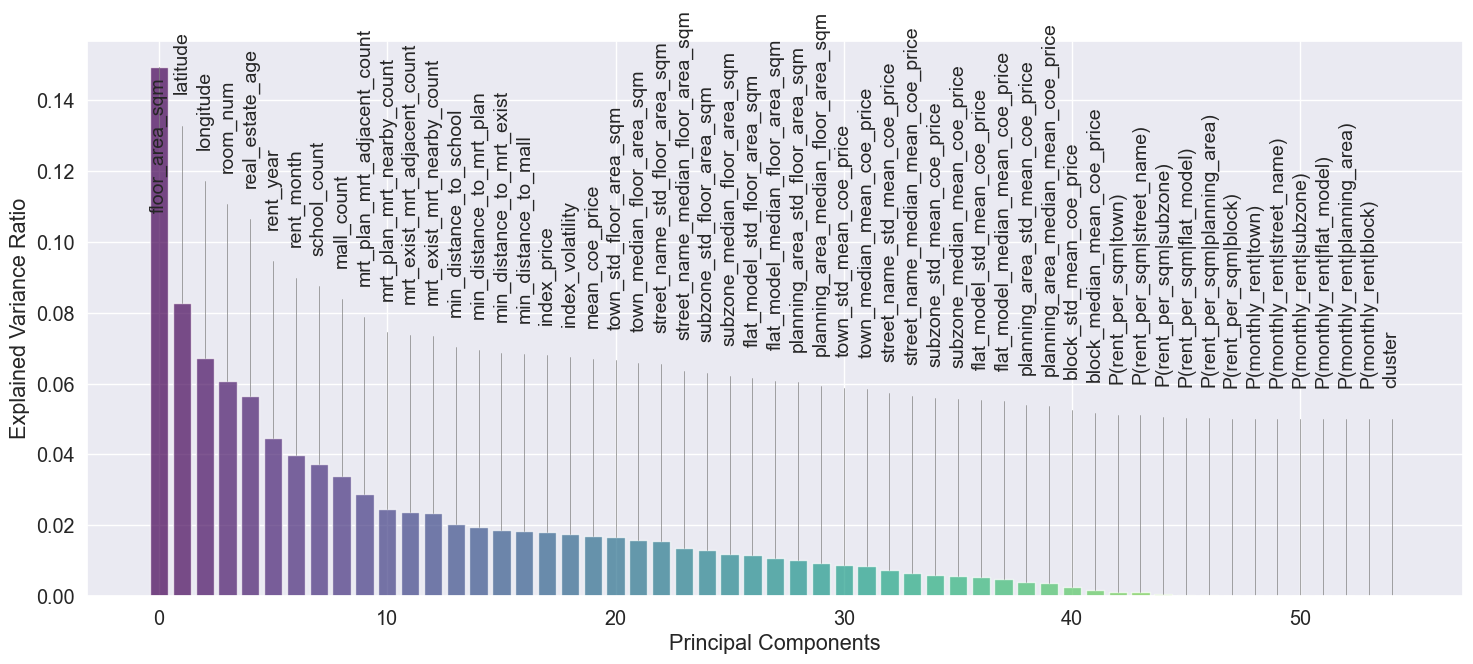

                                Feature  Contribution to Variance
0                        floor_area_sqm              1.493927e-01
1                              latitude              8.288159e-02
2                             longitude              6.710637e-02
3                              room_num              6.086060e-02
4                       real_estate_age              5.662340e-02
5                             rent_year              4.456055e-02
6                            rent_month              3.991723e-02
7                          school_count              3.745080e-02
8                            mall_count              3.384691e-02
9           mrt_plan_mrt_adjacent_count              2.879106e-02
10            mrt_plan_mrt_nearby_count              2.452584e-02
11         mrt_exist_mrt_adjacent_count              2.383226e-02
12           mrt_exist_mrt_nearby_count              2.339601e-02
13               min_distance_to_school              2.025557e-02
14        

In [55]:
#### 2.4 a) PCA
train_data_without_target = train_data.drop(columns=['monthly_rent'])

# 1. Standardize the data
scaler = StandardScaler()
train_data_standardized = scaler.fit_transform(train_data_without_target)

# 2. Perform PCA
pca = PCA()
pca_result = pca.fit(train_data_standardized)

# 3. Calculate the explained variance ratio for each feature
explained_variance_ratio = pca_result.explained_variance_ratio_
# Calculate the cumulative sum of the explained variance ratio
cumulative_variance = np.cumsum(explained_variance_ratio)
# Find the number of components required to explain at least 90% of the variance
num_components = np.where(cumulative_variance >= 0.90)[0][0] + 1

# Create a DataFrame to display feature contributions
feature_contributions = pd.DataFrame({
    'Feature': train_data_without_target.columns,
    'Contribution to Variance': explained_variance_ratio
})

# most_contribute_feature
most_contribute_feature = np.array(feature_contributions['Feature'])

# Plotting the explained variance ratio
feature_names = most_contribute_feature

# Plotting the explained variance ratio with feature names
plt.figure(figsize=(15, 7))  # Increase figure size for clarity
colors = plt.cm.viridis(np.linspace(0, 1, len(explained_variance_ratio)))  # Generate a color map
bars = plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio, alpha=0.7, align='center', color=colors)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')

# Add lines and text for feature names
for idx, (bar, feature) in enumerate(zip(bars, feature_names)):
    yval = bar.get_height()
    line_height = 0.05
    text_position = yval + line_height + 0.01  # Adjust text position above the line
    # Special adjustment for the first bar if it's too high
    if idx == 0 and yval + line_height > plt.ylim()[1]:
        line_height = -0.02  # Draw line downwards
        text_position = yval + line_height - 0.02  # Place text below the line
    plt.plot([idx, idx], [yval, yval + line_height], color='grey', lw=0.5)  # Draw a line from the bar
    plt.text(idx, text_position, feature, ha='center', rotation=90, fontsize=14)  # Place the text at the end of the line

plt.tight_layout()  # Adjust the layout to make room for the rotated labels
plt.show()

print(feature_contributions)

#### 3.7 b) Top-K Selection

In [ ]:
def get_top_k_features(dataset, k, standard=False):
    """
    Returns a DataFrame with the top-k most contributing features from train_data
    and the target feature 'monthly_rent'.

    Parameters:
    - k (int): Number of top features to select.
    - standard (Boolean): Whether to standardized or not

    Returns:
    - DataFrame: A DataFrame with the top-k features and the target feature.
    """

    # Top-K
    top_k_features = list(most_contribute_feature[:k])
    # Target
    top_k_features.append('monthly_rent')

    if standard:
        # Separate the target feature
        target_feature = dataset['monthly_rent'].copy()

        # Remove the target feature for standardization
        train_data_without_target = dataset.drop(columns=['monthly_rent'])

        train_data_standardized = StandardScaler().fit_transform(train_data_without_target)

        # Convert the array back to a DataFrame
        train_data_standardized_df = pd.DataFrame(train_data_standardized,
                                                  columns=train_data_without_target.columns)

        # Reset indices and add the target feature back to the standardized DataFrame
        train_data_standardized_df = train_data_standardized_df.reset_index(drop=True)
        target_feature = target_feature.reset_index(drop=True)
        train_data_standardized_df['monthly_rent'] = target_feature

    return dataset[top_k_features].copy()

# test_na_set = get_top_k_features(train_data, 20, True)
# nan_counts = test_na_set.isna().sum()
# features_with_nan = nan_counts[nan_counts > 0]
# print(features_with_nan)

#### 3.7 c) Variance contribution perccentage selection

In [ ]:
def get_var_percentage_features(dataset, percentage, standard=False):
    # Sum up contribution to variance
    total_variance = np.sum(feature_contributions['Contribution to Variance'])

    # Calculate the cumulative contribution to variance in percentage
    feature_contributions['Cumulative Contribution'] = feature_contributions['Contribution to Variance'].cumsum() / total_variance * 100

    # Find the number of features where the cumulative contribution is just over 90%
    k = feature_contributions[feature_contributions['Cumulative Contribution'] <= percentage].shape[0] + 1

    return get_top_k_features(dataset, k, standard)

# test_df = get_var_percentage_features(train_data, 95)
# test_df.head()

# 3. Save and load data

In [ ]:
# Save data into file
train_data.to_csv('preprocessed/train_data.csv', index=0)
test_data.to_csv('preprocessed/test_data.csv', index=0)
np.save('preprocessed/most_contribute_feature.npy', most_contribute_feature, allow_pickle=True)
feature_contributions.to_csv('preprocessed/feature_contributions.csv', index=0)

In [ ]:
# Load data from file
train_data = pd.read_csv('preprocessed/train_data.csv')
test_data = pd.read_csv('preprocessed/test_data.csv')
most_contribute_feature = np.load('preprocessed/most_contribute_feature.npy', allow_pickle=True)
feature_contributions = pd.read_csv('preprocessed/feature_contributions.csv')

# 4. Methods - Single Regressors

After EDA and data preprocessing, we can now apply data mining methods for prediction. In this section, we choose different algorithms to generate regression models, including Multiple Linear Regression, Random Forest, XGBoost and LightGBM. The general proposal is to split the preprocessed dataset into train/test data, train and validate with train data, and evaluate the optimized model performance with test data. Finally, compare the models to get a overall picture of how well these regression models perform.

Different modelling methods may involve different data processing and feature engineering techniques. Therefore, instead of using the train_data/test_data directly, we create separate copies of the dataset for each method to generate the corresponding training/testing data for that particular method.

### 4.0 General Evaluate Functions

In [ ]:
def plot_predict_vs_actual(y_actual, y_predict):
    plt.scatter(y_actual, y_predict)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs Predicted")
    plt.show()

## 4.1 Multiple Linear Regression

### Training

In [ ]:
# Get var percentage 90 features
data_mlr = get_var_percentage_features(train_data, 90, True)

# Split data into features and target
X = data_mlr.drop(['monthly_rent'], axis=1)
y = data_mlr['monthly_rent']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression
mlr = LinearRegression()

# Fit the model
mlr = mlr.fit(X_train, y_train)

### Evaluation

#### Evaluate the model on training dataset

In [ ]:
y_pred_train = mlr.predict(X_train)

# Model evaluation metrics
print('R^2:',metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

plot_predict_vs_actual(y_train, y_pred_train)

**Assumptions on MLR Models**

There are some main assumptions on Multiple Regression Models, which are listed below:

* Linearity
* No Multi-Collinearity
* Homoskedasticity
* Independence of independent variable
* Normality
* Independence of errors

We should conduct examinations on whether the assumptions above are satisfied in this context. Basic methods include using diagnostic plots for the relevant analysis. For example, we can use residual plots to check if homoskedasticity is violated or the errors' independency. Also, scatter plots of dependent versus independent variables can help us find non-linear relationships and so on.

* **Linearity**

Linearity in MLR means that the relationship between the independent variables (features) and the dependent variable (target) is linear.

In [ ]:
fig, axs = plt.subplots(ncols=len(X_train.columns), nrows=1, figsize=(100, 4))

axs = axs.flatten()
for i, k in enumerate(X_train.columns):
    sns.regplot(y=y_train, x=X_train[k], ax=axs[i], scatter_kws={"color": "teal"}, line_kws={"color": "red"})
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

We can observe from the plots that the relationship between the independent variables (features) and the dependent variable (target) is linear.

* **No Multi-Collinearity**

Multicollinearity occurs when two or more independent variables in the MLR model are highly correlated, making it difficult to separate their individual effects on the dependent variable. It can impact the reliability of your regression model's coefficients and predictions.

We use the Correlation Matrix to have a look at the multi-collinearity across all variables first. Look for high correlation coefficients (typically greater than 0.7) between pairs of variables. High correlations suggest multicollinearity.

In [ ]:
# Display Correlation Matrix
corrMatrix = X_train.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()

`flat_type` and `floor_area_sqm` has a correlation coefficient of 0.95, and `town` and `planning_area` has a correlation coefficient of 0.97. This may suggest multicollinearity.

Note that `flat_type`, `town` and `planning_area` are  encoded and is not numeric values by nature, so we may consider other encoding methods for avoiding multi-collinearity across the variables.

Then we use another metrics Variance Inflation Factor (VIF) to measure how much the variance of the estimated regression coefficients is increased due to multi-collinearity. Calculate the VIF for each independent variable. High VIF values (typically greater than 10) indicate multicollinearity.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame({
    'variables': X_train.columns,
    'VIF': [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
}).sort_values(by='VIF', ascending=True)

print(vif.head(10))

As mentioned above, high VIF values (typically greater than 10) indicate multicollinearity. The form shows features "flat_type", "floor_area_sqm", "real_estate_age", "rent_year", "school_count" and "mall_count" may have issues of multicollinearity, among which the VIF value of "rent_year" is especially high, suggesting the potential inner problem.

* **Homoskedasticity**

Homoscedasticity means that the variance of the residuals (the differences between the observed values and the predicted values) is constant across all levels of the independent variables. If homoscedasticity is violated, it can lead to problems such as biased coefficient estimates and incorrect inference.

In [ ]:
plt.scatter(y_pred_train, y_train - y_pred_train)
plt.title("Residual vs Fit Plot")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

We can observe that there is a random scattering of points with no discernible pattern. As in a homoskedastic dataset, the points should be evenly scattered around the horizontal line at 0 (the residuals have constant variance), we can come to the conclusion that the Homoskedasticity is not violated.

Also, we do not observe a funnel-shaped, fan-shaped pattern, or any other systematic change in the spread of residuals as the fitted values change, which suggests heteroskedasticity (the variance of residuals is not constant).

* **Independence of independent variables**

MLR assumes that independent variables are not perfectly correlated with each other (i.e., they are independent). Violations of this assumption can lead to unstable coefficient estimates and difficulties in interpreting their individual effects. We perform check of the independence, and some typical ones are shown below.

In [ ]:
# Independence of X variables-'floor_area_sqm'
plt.scatter(X_train['floor_area_sqm'], y_train - y_pred_train)
plt.title("Floor Area Size vs Residuals")
plt.xlabel("floor_area_sqm")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# Independence of X variables-'latitude'
plt.scatter(X_train['latitude'], y_train - y_pred_train)
plt.title("Latitude vs Residuals")
plt.xlabel("latitude")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# Independence of X variables-'longitude'
plt.scatter(X_train['longitude'], y_train - y_pred_train)
plt.title("Longitude vs Residuals")
plt.xlabel("latitude")
plt.ylabel("Residuals")
plt.show()

The plots above all show that residuals do appear randomly and symmetrically distributed around zero under all conditions, which prove the independence.

* **Normality**

MLR assumes that the residuals (the differences between the observed and predicted values) are normally distributed. Deviations from normality can impact the validity of statistical inference, such as hypothesis tests and confidence intervals.

In [ ]:
# Normality of residuals
sns.distplot(y_train - y_pred_train)
plt.title("Normality of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

We can see from the plot above that the residuals are normally distributed, which means the normality assumption is satiefied.

* **Independence of errors**

Independence of errors states that the residuals (the differences between the observed values and the predicted values) should be independent of each other. Violations of this assumption can lead to incorrect parameter estimates, unreliable hypothesis tests, and inaccurate predictions.

Here we use *Durbin-Watson Test* for checking independence of errors. This statistical test checks for the presence of autocorrelation in the residuals. A Durbin-Watson statistic value close to 2 indicates no autocorrelation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson_statistic = durbin_watson(y_train - y_pred_train)
print(f'Durbin-Watson Statistic: {durbin_watson_statistic}')

The Durbin-Watson statistic value is close to 2, which means there is no autocorrelation (i.e. the assmuption is satisfied).

#### Evaluate the model on test dataset

After the evalution on the training dataset, as well as the checks for MLR assmuptions and corresponding model refinement, we can use the model as the final  MLR model and evaluate its performance on the test dataset.

In [ ]:
y_pred_test = mlr.predict(X_test)

# Model evaluation metrics
print('R^2:',metrics.r2_score(y_test, y_pred_test))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:',metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

### Analysis

By looking at the training and testing result of the multiple linear regression model, we could find that the R^2 and RMSE is not very ideal. This might due to we use a very intuitive selection of features, and the simple structure of linear regression model could not handle the complexity of such multiple dimensions. Also we have noticed that there are inner problems of the multiple linear regression model such as the multi-collinearity, which suggests a single MLR model is not an potimal choice in the current context. But still we could base on this model to provide insights on other models, for example the selection of the input features.

## 4.2 Support Vector Regression

### Training

In [ ]:
# Get var percentage 90 features with standardization
data_svr = get_var_percentage_features(train_data, 90, True)

# Split data into features and target
X = data_svr.drop(['monthly_rent'], axis=1)
y = data_svr['monthly_rent']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Support Vector Regression with appropriate parameters
svr = SVR(kernel='linear', C=1.0, epsilon=0.2)

# Fit the model
svr = svr.fit(X_train, y_train)

### Evaluating

In [ ]:
y_pred_train = svr.predict(X_train)

# Model evaluation metrics
print('R^2:',metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

plot_predict_vs_actual(y_train, y_pred_train)

## 4.3 Random Forest

### Training

In [ ]:
# Get top k features
data_rf = get_var_percentage_features(train_data, 90)

# Split data into features and target
X = data_rf.drop(['monthly_rent'], axis = 1)
y = data_rf['monthly_rent']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Define XGBoost hyperparameters
# We use GridSearchCV as a technique to systematically search through different combinations of hyperparameters
rf_param_grid = {
    'max_depth': [80, 90, 100], # Maximum number of levels in each decision tree
    'max_features': [2, 3], # Maximum number of features considered for splitting a node
    'min_samples_leaf': [1, 3, 4, 5], # Minimum number of data points allowed in a leaf node
    'n_estimators': [100, 300, 600], # Number of trees in the forest
}

# Initialize RandomForest regressor and GridSearchCV
rf_reg = RandomForestRegressor(random_state = 42)
rf_grid = GridSearchCV(estimator = rf_reg, param_grid = rf_param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
rf_grid = rf_grid.fit(X_train, y_train)

# Display best hyperparameters
print()
print('Best hyperparameters:')
print(rf_grid.best_params_)

# Get the best RF estimator based on best parameters generated from above
rf_best = rf_grid.best_estimator_

### Evaluating

In [ ]:
# Predict on training set
y_pred_train = rf_best.predict(X_train)

# Display training set evaluation metrics
print('Training Metrics:')
print('R^2:',metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

# Predict on testing set
y_pred_test = rf_best.predict(X_test)

# Display testing set evaluation metrics
print()
print('Testing Metrics:')
print('R^2:',metrics.r2_score(y_test, y_pred_test))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:',metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

# Display feature importances
rf_features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Score': rf_best.feature_importances_
}).sort_values(by='Importance Score', ascending=False)
print()
print('Top 10 important features:')
print(rf_features.head(10))

## 4.4 Gradient Boost Regressor

### Training

In [ ]:
# Get top k features
data_gb = get_var_percentage_features(train_data, 90)

# Split data into features and target
X = data_gb.drop(['monthly_rent'], axis=1)
y = data_gb['monthly_rent']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define GBoost hyperparameters
gb_param_grid = {
    'loss': ["ls", "lad", "huber"],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 8, 10],
    'min_samples_leaf': [100, 150, 250],
    'max_features': [0.3, 0.1]
}

# Initialize GradientBoostingRegressor
gb_reg = GradientBoostingRegressor()
gb_grid = GridSearchCV(estimator=gb_reg, param_grid=gb_param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)

# Fit the model
gb_grid = gb_grid.fit(X_train, y_train)

# Display best hyperparameters
print()
print('Best hyperparameters:')
print(gb_grid.best_params_)

# Get best estimator
gb_best = gb_grid.best_estimator_

### Evaluating

In [ ]:
# Predict on training set
y_pred_train = gb_best.predict(X_train)

# Display training set evaluation metrics
print('Training Metrics:')
print('R^2:', metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_train, y_pred_train)) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

# Predict on testing set
y_pred_test = gb_best.predict(X_test)

# Display testing set evaluation metrics
print()
print('Testing Metrics:')
print('R^2:',metrics.r2_score(y_test, y_pred_test))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:',metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

# Display feature importances
gb_features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Score': gb_best.feature_importances_
}).sort_values(by='Importance Score', ascending=False)
print()
print('Top 10 important features:')
print(gb_features.head(10))

# Plot top 10 feature importances
plot_importance(gb_best, max_num_features=10)

## 4.5 XGBoost Regressor

### Training

In [ ]:
# Get top k features
data_xgb = get_var_percentage_features(train_data, 90)

# Split data into features and target
X = data_xgb.drop(['monthly_rent'], axis=1)
y = data_xgb['monthly_rent']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost hyperparameters
xgb_param_grid = {
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [6, 8, 9, 10],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3],
    "colsample_bytree": [0.3, 0.4, 0.6, 0.8]
}

# Initialize XGBoost regressor and GridSearchCV
xgb_reg = xgb.XGBRegressor(seed=42, objective='reg:squarederror')
xgb_grid = GridSearchCV(estimator=xgb_reg, param_grid=xgb_param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
xgb_grid = xgb_grid.fit(X_train, y_train)

# Display best hyperparameters
print()
print('Best hyperparameters:')
print(xgb_grid.best_params_)

# Get best estimator
xgb_best = xgb_grid.best_estimator_

### Evaluating

In [ ]:
# Predict on training set
y_pred_train = xgb_best.predict(X_train)

# Display training set evaluation metrics
print('Training Metrics:')
print('R^2:', metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_train, y_pred_train)) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

# Predict on testing set
y_pred_test = xgb_best.predict(X_test)

# Display testing set evaluation metrics
print()
print('Testing Metrics:')
print('R^2:',metrics.r2_score(y_test, y_pred_test))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:',metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

# Display feature importances
xgb_features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Score': xgb_best.feature_importances_
}).sort_values(by='Importance Score', ascending=False)
print()
print('Top 10 important features:')
print(xgb_features.head(10))

# Plot top 10 feature importances
plot_importance(xgb_best, max_num_features=10)

## 4.6 LightGBM Regressor

### Training

In [ ]:
# Get top k features
data_lgbm = get_var_percentage_features(train_data, 90)

# Split data into features and target
X = data_lgbm.drop(['monthly_rent'], axis=1)
y = data_lgbm['monthly_rent']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost hyperparameters
lgbm_param_grid = {
    'metric': ['rmse'],
    'max_depth': [9,10,11,12,13], 
    'bagging_fraction': [0.8, 0.9, 1],
    'feature_fraction': [0.8, 0.9, 1],
    'min_data_in_leaf': [20,50,80],
    'learning_rate': [0.01,0.05,0.1,0.2]
}

# Initialize LightGBM regressor and GridSearchCV
lgbm_reg = lgb.LGBMRegressor(seed = 42, num_iterations = 1200)
lgbm_grid = GridSearchCV(estimator=lgbm_reg, param_grid=lgbm_param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
lgbm_grid = lgbm_grid.fit(X_train, y_train)

# Display best hyperparameters
print()
print('Best hyperparameters:')
print(lgbm_grid.best_params_)

# Get best estimator
lgbm_best = lgbm_grid.best_estimator_

### Evaluating

In [ ]:
# Predict on training set
y_pred_train = lgbm_best.predict(X_train)

# Display training set evaluation metrics
print('Training Metrics:')
print('R^2:', metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_train, y_pred_train)) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

# Predict on testing set
y_pred_test = lgbm_best.predict(X_test)

# Display testing set evaluation metrics
print()
print('Testing Metrics:')
print('R^2:',metrics.r2_score(y_test, y_pred_test))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:',metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

# Display feature importances
lgbm_features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Score': lgbm_best.feature_importances_
}).sort_values(by='Importance Score', ascending=False)
print()
print('Top 10 important features:')
print(lgbm_features.head(10))

# Plot top 10 feature importances
plot_importance(lgbm_best, max_num_features=10)

# 5. Method - Ensemble Models

## 5.1 Baseline

In [ ]:
# *******************Linear model*******************
def get_model():
    net = nn.Sequential(nn.Linear(in_features, 64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.Linear(32, 1),)
    return net

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Adam optimization
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_model()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_model()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
    test_data['Predicted'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([df_id['Id'], test_data['Predicted']], axis=1)
    return submission, train_ls

In [ ]:
# train_data.reset_index(drop=True, inplace=True)
# train_data.head()

In [ ]:
train_len = train_data.shape[0] * 0.8
numeric_attributes=['flat_type', 'floor_area_sqm', 'latitude', 'longitude']
train_data_linear = train_data.loc[:train_len-1,numeric_attributes]
train_data_rent = train_data.loc[:train_len-1,['monthly_rent']]
train_data_rent.shape

In [ ]:
test_data_linear = train_data.loc[train_len:,numeric_attributes]
test_data_linear.head()
print(train_data_linear.shape, test_data_linear.shape)

In [ ]:
train_attributes = torch.tensor(train_data_linear.values, dtype=torch.float32)
test_attributes = torch.tensor(test_data_linear.values, dtype=torch.float32)
train_labels_linear = torch.tensor(train_data_rent.values.reshape(-1, 1), dtype=torch.float32)
loss = nn.MSELoss()
in_features = train_attributes.shape[1]

In [ ]:
# train linear model
k, num_epochs, lr, weight_decay, batch_size = 5, 600, 0.01, 0, 64 # adjust hyperparameter
train_l, valid_l = k_fold(k, train_attributes, train_labels_linear, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold cross-validation: average train log rmse: {float(train_l):f}, '
      f'average test log rmse: {float(valid_l):f}')

In [ ]:
# predict linear model
submission, train_ls = train_and_pred(train_attributes, test_attributes, train_labels_linear, test_data,
               num_epochs, lr, weight_decay, batch_size)
# score = self_evaluation(submission)


In [ ]:
submission.to_csv('result/submission_linear_rmsle'+str(float(train_ls[-1]))[:6]+'.csv', index=False)

In [ ]:
# Define error metrics
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# k-fold Cross Validation
# set verbose=3 for more details
def rmsle_cross_val(X_train, y_train, n_folds, model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return rmse

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

#### 5.1 b) Self-Defined Linear NN Model

In [ ]:
# Define the neural network model
class LinearModel(nn.Module):
    def __init__(self, in_features):
        super(LinearModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# RMSE loss function
def log_rmse(preds, labels):
    clipped_preds = torch.clamp(preds, 1, float('inf'))
    return torch.sqrt(nn.MSELoss()(torch.log(clipped_preds), torch.log(labels)))

# Training function
def train_model(model, train_loader, optimizer, loss_fn):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate_model(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in data_loader:
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Load data
train_data.reset_index(drop=True, inplace=True)
train_len = int(train_data.shape[0] * 0.8)
numeric_attributes = ['flat_type', 'floor_area_sqm', 'latitude', 'longitude']

train_features = torch.tensor(train_data.iloc[:train_len][numeric_attributes].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.iloc[:train_len]['monthly_rent'].values.reshape(-1, 1), dtype=torch.float32)
test_features = torch.tensor(train_data.iloc[train_len:][numeric_attributes].values, dtype=torch.float32)

dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model, optimizer, and loss
model = LinearModel(train_features.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training and evaluation
num_epochs = 600
for epoch in range(num_epochs):
    train_model(model, train_loader, optimizer, loss_fn)
    train_loss = evaluate_model(model, train_loader, log_rmse)
    if epoch % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

# Predictions
model.eval()
with torch.no_grad():
    predictions = model(test_features)

# Create submission dataframe
submission = pd.DataFrame({
    'Id': range(len(predictions)),
    'Predicted': predictions.squeeze().numpy()
})

submission.to_csv('result/submission_linear_rmsle'+str(float(train_ls[-1]))[:6]+'.csv', index=False)

5.2 Lasso Model

In [ ]:
# *******************Lasso model*******************
# lasso_alphas = [0.00001, 0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
# model_lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1000,alphas =lasso_alphas, random_state=42, cv=kfolds))
# model_lasso = make_pipeline(RobustScaler(), Lasso(max_iter=1000, alpha =0.00005, random_state=42))
model_lasso = Lasso(max_iter=1000, alpha =0.00005, tol=0.1, random_state=42)
score_lasso = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))
model_lasso.fit(train_data_linear.values, train_data_rent.values)
model_lasso_pred = model_lasso.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lasso_pred), columns = ['Predicted'])
model_lasso_pred, df_pred['Predicted']
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_lasso_rmse'+str(float(score_lasso.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************ENet model*******************
# enet_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
# enet_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
model_ENet = make_pipeline(RobustScaler(), ElasticNet(max_iter=3000, alpha=0.0005, l1_ratio=0.8, tol=0.2, random_state=42))
score_ENet = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score_ENet.mean(), score_ENet.std()))
model_ENet.fit(train_data_linear.values, train_data_rent.values)
model_ENet_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ENet_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_enet_rmse'+str(float(score_ENet.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************Ridge model*******************
ridge_alphas = [1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
model_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kfolds))
# model_ridge = make_pipeline(RobustScaler(), Ridge(max_iter=1000, alpha=0.1))
score_ridge = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))
model_ridge.fit(train_data_linear.values, train_data_rent.values)
model_ridge_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ridge_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_ridge_rmse'+str(float(score_ridge.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************SVR model*******************
# C = [0.1, 0.5, 1, 50, 100, 1000]
# epsilon = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# C:5 - 0.1163 (0.0032), C:10 - 0.1140 (0.0034), epsilon: 0.05 - 0.1105 (0.0039)
model_svr = make_pipeline(RobustScaler(), SVR(C=10, epsilon=0.05, gamma='scale'))
score_svr = rmsle_cross_val(train_data_linear, np.log(train_data_rent), 5, model_svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score_svr.mean(), score_svr.std()))

model_svr.fit(train_data_linear.values, np.log(train_data_rent.values))
model_svr_pred = model_svr.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(np.exp(model_svr_pred)), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_svr_rmsle'+str(float(score_svr.mean()))[:7]+'.csv', index=False)

In [ ]:
test_data.head()

In [ ]:
train_data.head()

In [ ]:
# init train data and test data for non-linear model
all_data_ensemble = train_data.copy()
# test_data_linear = train_data.loc[train_len*0.8:,numeric_attributes]
train_data_ensemble = train_data.copy().drop(columns = ['monthly_rent'])
# test_data_ensemble = test_data.copy().drop(columns = ['Predicted'])
test_data_ensemble = test_data.copy()
train_data_rent = train_data.loc[:train_len/0.8,['monthly_rent']]
train_data_ensemble.shape, test_data_ensemble.shape

In [ ]:
train_data_ensemble.head()

In [ ]:
train_data_rent.head()

In [ ]:
# *******************Random Forest model*******************
# use grid search to produce a baseline rf model
model_rf = RandomForestRegressor(oob_score=True, random_state=3, n_jobs=-1)
params ={
    'n_estimators': [1300],# [800, 900, 1000, 1200, 1500],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [None, 0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8, 10, 15, 20],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_ensemble, train_data_rent)
    if model_rf.oob_score_ > best_score:
        best_score = model_rf.oob_score_
        best_grid = g
        print('oob:', best_score, best_grid)
# oob: 0.9764868974915827 {'max_depth': 35, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1300}

In [ ]:
# check feature importance
def RF_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_ensemble, train_data_rent)
feature_imp = RF_importance(model_rf, train_data_ensemble)
print(model_rf.oob_score_)
print(feature_imp)

In [ ]:
# feature selection
Threshold = 0.0009
to_keep = feature_imp[feature_imp.imp>Threshold].cols
to_keep = [col for _, col in to_keep.items()]
print(to_keep)
df_keep = train_data_ensemble[to_keep].copy()
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(df_keep, train_data_rent)
score_rf = rmsle_cross_val(train_data_ensemble, train_data_rent, 5, model_rf)
print(model_rf.oob_score_, score_rf.mean())

In [ ]:
# deep selection
# keep_cols imp >= 0.01
keep_cols = ['rent_approval_date', 'latitude', 'longitude', 'floor_area_sqm', 'flat_type', 'lease_commence_date', 'flat_model', 'planning_area', 'town', 'region']
cols = to_keep
scores = []
feats = []
for col in cols:
    tmp = to_keep.copy()
    if col in keep_cols:
        continue
    tmp.remove(col)
    df_tmp = train_data_ensemble[tmp].copy()
    model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
    model_rf.fit(df_tmp, train_data_rent)
    scores.append(model_rf.oob_score_)
    feats.append(col)

to_del = sorted(zip(scores, feats), reverse=True)
to_del

In [ ]:
# fine-tuning
# delete increase less than 0.0001
to_keep_final = ['latitude', 'lease_commence_date', 'longitude', 'flat_type', 'flat_model', 'floor_area_sqm',
                 'rent_approval_date']
train_data_final = train_data_ensemble[to_keep_final].copy()
model_rf = RandomForestRegressor(oob_score=True, n_jobs=-1)
params ={
    'n_estimators': [1200, 1250,1280],# [1200, 1250, 1280, 1300, 1350, 1400],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_final, train_data_rent)
    if model_rf.oob_score_ > best_score:
        score_rf = rmsle_cross_val(train_data_final, train_data_rent, 5, model_rf)
        best_score = model_rf.oob_score_
        best_grid = g
        print('best oob:', best_score, best_grid, 'score:', score_rf.mean())

In [ ]:
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1250, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_final, train_data_rent)

In [ ]:
test_data_final = test_data_ensemble[to_keep_final]
# print(test_data_final)
model_rf_pred=model_rf.predict(test_data_final)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_rf_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_rf_'+str(best_score)[:7]+'.csv', index=False)

In [ ]:
# *******************GBoost model*******************
model_GBoost = GradientBoostingRegressor(n_estimators=7000, learning_rate=0.1,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =42)
score_GBoost = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_GBoost)
print("GradientBoostingRegressor score: {:.4f} ({:.4f})\n".format(score_GBoost.mean(), score_GBoost.std()))

model_GBoost.fit(train_data_ensemble.values, train_data_rent.values)
model_gb_pred = model_GBoost.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_gb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_gb_rmsle'+str(float(score_GBoost.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************XGB model*******************
# xgb_params = dict(
#     max_depth=6,           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     num_parallel_tree=1,   # set > 1 for boosted random forests
# )
model_xgb = xgb.XGBRegressor(learning_rate=0.01, gamma=0,
                             max_depth=5, min_child_weight = 1,
                             n_estimators=6000, colsample_bytree=0.6,
                             reg_alpha=0.5, reg_lambda=1.0,
                             subsample=0.7, random_state = 42, nthread = -1)
score_xgb = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_xgb)
print("XGB score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

model_xgb.fit(train_data_ensemble.values, train_data_rent.values)
model_xgb_pred = model_xgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_xgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_xgb_rmsle'+str(float(score_xgb.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************LightGBM model*******************
# Use large max_bin (may be slower)
# Use small learning_rate with large num_iterations
# Use large num_leaves (may cause over-fitting)
model_lgb = lgb.LGBMRegressor(objective='regression',
                       num_leaves=25, learning_rate=0.05,
                       max_bin = 200, n_estimators=1000,
                       random_state=42)
score_lgb = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_lgb)
print("LGB score: {:.4f} ({:.4f})\n".format(score_lgb.mean(), score_lgb.std()))

model_lgb.fit(train_data_ensemble.values, train_data_rent.values)
model_lgb_pred = model_lgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_lgb_rmsle'+str(float(score_lgb.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************RF model*******************
model_RF = RandomForestRegressor(n_jobs=-1, n_estimators=1250, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_RF.fit(train_data_ensemble.values, train_data_rent.values)

In [ ]:
# *******************Stacking model*******************
model_stack = StackingCVRegressor(regressors=(model_GBoost, model_xgb, model_lgb),
                                meta_regressor=model_rf,
                                use_features_in_secondary=True)
score_stack = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_stack)
print("Stacked score: {:.4f} ({:.4f})\n".format(score_stack.mean(), score_stack.std()))
# fitting stacked model
model_stack.fit(train_data_ensemble.values, train_data_rent.values)
model_stack_pred = model_stack.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_stack_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('/submission_stacked_rmsle'+str(float(score_stack.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************Blend models/Weighting*******************
def blended_predictions(X):
    return ((0.05 * model_GBoost.predict(X)) + \
            (0.1 * model_xgb.predict(X)) + \
            (0.1 * model_lgb.predict(X)) + \
            (0.55 * model_RF.predict(X)) + \
            (0.2 * model_stack.predict(X)))

model_blend_pred = blended_predictions(train_data_ensemble.values)
score_blend = rmse(np.log(train_data_rent.values), np.log(model_blend_pred))
print(score_blend)

In [ ]:
model_blended_pred = blended_predictions(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_blended_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_blended_rmsle'+str(score_blend)[:7]+'.csv', index=False)